# 局部极限学习机(locELM)和随机特征方法(PU-RFM)

## 局部极限学习机(locELM)

### 局部极限学习机（locELM）：区域分解与ELM结合的PDE求解框架
局部极限学习机（local Extreme Learning Machine，简称locELM）是将**区域分解法**与**极限学习机（ELM）** 结合的无网格PDE求解方法，核心是通过“分域建模+局部ELM拟合”实现高效的偏微分方程求解。


#### 核心步骤：分域与局部建模
locELM的基础是**区域分解**：
将PDE的求解域$\Omega$划分为$N_e$个**非重叠子域**，即：
$$\Omega = \bigcup_{s=1}^{N_e} \Omega_s\tag{10.1}$$

在每个子域$\Omega_s$上，用**局部ELM网络**表示该子域内的解：
$$u_s(x) = \sum_{j=1}^M w_{s,j} V_{s,j}(x)\tag{10.2}$$

其中各组件的定义为：
- $V_{s,j}(x)$：最后一层隐藏层的输出，其对应的隐藏层权重、偏置是**随机生成后固定的**（ELM的核心特性）；
- $w_{s,j}$：仅有的可训练参数（输出层权重）；
- $M$：隐藏层神经元数量，控制局部模型的表达能力。


#### 训练简化：仅优化输出层权重
由于隐藏层参数是随机固定的，locELM的训练过程被简化为**求解最小二乘问题**：
只需通过拟合“子域内的PDE残差”和“子域边界的约束条件”，优化输出层权重$w_{s,j}$即可。

这种设计的优势是：训练从“深度网络的非凸优化”转化为“线性/非线性最小二乘”，计算效率大幅提升。


#### 关键约束：子域接口的连续性
为保证整个求解域内解的一致性，locELM需要在**子域接口处**满足$C^k$连续性条件，这一步是locELM的核心约束：通过在接口处添加匹配条件，将各局部模型“拼接”为全局连续的解。


locELM的核心逻辑是分而治之：
$$\text{locELM} = \text{区域分解法} + \text{局部ELM网络} + \text{最小二乘训练}\tag{10.3}$$
它既利用区域分解降低了单域的求解规模，又借助ELM的“随机隐藏层+线性训练”特性实现了高效计算，是无网格PDE求解的一类轻量化方法。



全局ELM的核心瓶颈在于：为保证求解精度，需要设置**极大的隐藏层规模$M$**，这会导致对应的线性方程组变得稠密且计算成本陡增。而区域分解法则是解决这一问题的关键策略。


#### 区域分解带来的核心优势
1. **计算规模局部化**：
   每个子域仅需求解**小规模最小二乘问题**：
   $$w_s^* = \arg \min_{w} \left\| A_s w - b_s \right\|^2 \tag{10.4}$$
   避免了全局ELM的大规模稠密矩阵运算。

2. **全局矩阵稀疏化**：
   子域间仅通过“接口条件”耦合，因此全局最小二乘矩阵会从“稠密”变为“稀疏”，大幅降低存储与计算开销。

3. **训练效率线性提升**：
   训练时间随子域数量的增加呈**近线性下降**（分而治之的并行化特性）。

4. **求解精度提升**：
   局部化逼近更适配子域内的解特性，通常能带来更高的求解精度。


以泊松方程为例，子域接口处需满足 **$C^1$连续性约束** ：
$$u_s = u_{s'}, \quad \partial_n u_s = \partial_n u_{s'}\tag{10.5}$$
（即接口处的函数值、法向导数均需与相邻子域的解保持一致）。

区域分解让locELM同时具备“局部化求解”与“全局稀疏耦合”的特性，其计算效率可与有限元法（FEM）媲美，且往往更高效——这也是locELM能成为轻量化PDE求解器的核心原因。


---

### 局部ELM求解泊松方程：公式与实现逻辑
局部ELM（locELM）是一种基于分块建模的无网格PDE求解方法，其核心是通过**线性代数运算**（无需梯度下降）在每个子域上拟合约束，以下是其求解泊松方程的完整公式推导：


#### 1. 子域上的解表示
在每个子域$\Omega_s$内，用基函数的线性组合表示局部解：
$$u_s(x) = \sum_{j=1}^M w_{s,j} v_{s,j}(x) \tag{10.6}$$
其中：
- $v_{s,j}(x)$是子域$\Omega_s$上的基函数（局部ELM中通常为随机特征激活函数）；
- $w_{s,j}$是该子域模型的**可训练权重**。


#### 2. 配点处的PDE约束
在子域内选取的配点$x_{s,p}$处，强制满足泊松方程$-\Delta u = f$：
$$-\Delta u_s(x_{s,p}) = f(x_{s,p}) \tag{10.7}$$

由于$u_s$是$w_{s,j}$的线性组合，对其求拉普拉斯算子后仍保持线性性：
$$-\Delta u_s = \sum_{j=1}^M w_{s,j}(-\Delta v_{s,j})\tag{10.8}$$
这一步将PDE约束转化为关于$w_{s,j}$的线性方程。


#### 3. 边界条件约束
在子域的边界点$x_{b,p}$处，强制满足 Dirichlet 边界条件$u = g$：
$$u_s(x_{b,p}) = g(x_{b,p})\tag{10.9}$$


#### 4. 接口处的$C^1$连续性约束
为保证全局解的光滑性，在相邻子域$\Omega_s$与$\Omega_{s'}$的接口处，需同时满足**解的连续性**和**法向导数的连续性**（即$C^1$光滑性）：
$$u_s = u_{s'},\quad \partial_n u_s = \partial_n u_{s'}\tag{10.10}$$
（$\partial_n$表示沿接口法向的偏导数）


#### 5. 线性系统与最小二乘求解
将上述所有约束（PDE配点约束、边界条件、接口连续性）整合为一个**全局线性系统**：
$$A\boldsymbol{w} = \boldsymbol{b}\tag{10.11}$$
其中$\boldsymbol{w}$是所有子域可训练权重的集合，$A$是约束对应的系数矩阵，$\boldsymbol{b}$是约束的目标值向量。

最终通过**最小二乘法**求解该线性系统，得到最优权重：
$$\boldsymbol{w}^* = \arg \min_{\boldsymbol{w}} \|A\boldsymbol{w} - \boldsymbol{b}\|^2\tag{10.12}$$


局部ELM的关键特点是**无梯度、无反向传播**——所有约束都转化为线性代数问题，仅需通过矩阵运算即可求解，大幅降低了计算复杂度与实现难度。



---

## 随机特征方法(PU-RFM)
### 随机特征方法（PU-RFM）：基于重叠子域的全局光滑解构建
随机特征方法（Partition-of-Unity Random Feature Method，简称PU-RFM）是一类**基于重叠区域分解+单位分解**的PDE求解方法，与局部ELM的核心差异在于“子域重叠”与“加权融合”的设计。


#### PU-RFM的核心策略
PU-RFM的三大关键组件是：
- **重叠式区域分解**：
  将求解域$\Omega$划分为$K$个**存在非空重叠区域**的子域，即：
  $$\Omega = \bigcup_{k=1}^K \Omega_k, \quad \Omega_i \cap \Omega_j \neq \emptyset\tag{10.13}$$
  重叠设计让子域间的信息传递更自然，避免了非重叠子域接口处的强约束。

- **局部随机特征模型**：
  在每个重叠子域$\Omega_k$上，独立构建随机特征模型$u_k(x)$（形式与局部ELM的子域模型类似，即随机隐藏层+线性输出层）。

- **单位分解（PU）融合**：
  通过“单位分解权重”将局部模型加权组合为全局解——这是PU-RFM的核心创新。


#### 核心思想：单位分解的加权融合
全局解的构造方式是：
$$u(x) = \sum_{k=1}^K \psi_k(x) u_k(x)\tag{10.14}$$

其中$\psi_k(x)$是**单位分解权重**，需满足两个条件：
1. **支撑性**：$\psi_k(x)$仅在对应的重叠子域$\Omega_k$上非零；
2. **单位性**：对任意$x \in \Omega$，有$\sum_{k} \psi_k(x) = 1$。

这种加权方式能保证：全局解是局部模型的光滑组合（重叠区域的权重平滑过渡），无需额外施加接口连续性约束。


#### 与局部ELM的关联
PU-RFM与局部ELM的目标一致（用局部随机模型求解PDE），但实现方式更灵活：
- 局部ELM依赖“非重叠子域+接口强约束”；
- PU-RFM通过“重叠子域+单位分解加权”，天然实现全局光滑性，无需显式接口约束。


PU-RFM的本质是“**重叠子域的随机特征模型 + 单位分解的光滑融合**”，它能从多个局部随机特征模型中，自动构建出全局光滑的PDE解——是无网格PDE求解中兼顾“局部高效”与“全局光滑”的一类方法。


### 子域$\boldsymbol{\Omega_k}$上的局部随机特征模型：迭代一致的并行求解逻辑
在重叠子域$\Omega_k$上，局部随机特征模型是实现“并行求解+全局一致”的核心单元，其设计同时兼顾了PDE约束与子域间的信息协调。


#### 子域上的随机特征模型形式
在每个重叠子域$\Omega_k$上，用随机特征模型表示局部解：
$$u_k(x) = \sum_{j=1}^{m_k} \beta_{k,j} \sigma\left(w_{k,j}^\top x + b_{k,j}\right)\tag{10.15}$$
其中：
- $w_{k,j}$（权重）、$b_{k,j}$（偏置）是从分布$\rho_k$中随机采样的固定参数；
- $\beta_{k,j}$是该子域模型的**可训练输出层权重**；
- $\sigma$为激活函数（如tanh）。


#### 局部PDE约束的施加
在子域$\Omega_k$内部，模型需满足PDE的近似关系：
$$\mathcal{L}u_k(x) \approx f(x), \quad x \in \Omega_k\tag{10.16}$$
（$\mathcal{L}$是PDE对应的微分算子，例如泊松方程中$\mathcal{L}=-\Delta$）


#### 迭代式局部最小二乘优化
第$n+1$次迭代中，子域的可训练参数$\beta_k^{(n+1)}$通过求解以下最小二乘问题得到：
$$\beta_k^{(n+1)} = \arg \min_{\beta_k} \underbrace{\sum_{x_i \in \Omega_k} \left| \mathcal{L}u_k(x_i; \beta_k) - f(x_i) \right|^2}_{\text{PDE约束项}} + \lambda \underbrace{\sum_{x_i \in \Omega_k \cap \Omega_{nb}} \left| u_k(x_i; \beta_k) - u_{nb}^{(n)}(x_i) \right|^2}_{\text{相邻子域一致性项}}\tag{10.17}$$

这个优化目标的核心逻辑是“双约束”：
- **PDE约束项**：保证模型在子域内满足PDE；
- **一致性项**：通过超参数$\lambda$控制重叠区域与相邻子域上一轮解$u_{nb}^{(n)}$的匹配程度；
- $\Omega_{nb}$表示与$\Omega_k$重叠的相邻子域。


每个子域的最小二乘问题是**完全独立的**，因此所有子域的模型可以同时并行训练——仅需在每轮迭代后交换“重叠区域的解”即可实现全局一致性。


这种设计既保留了随机特征模型“局部轻量化”的优势，又通过“迭代式信息交换”避免了全局矩阵的组装，是兼顾“效率”与“一致性”的关键策略。


### 并行施瓦茨型接口更新：神经施瓦茨PDE求解器的核心逻辑
并行施瓦茨型接口更新是重叠子域随机特征方法的“迭代协调机制”，通过子域间的接口信息交换，实现全局解的一致性——这是一类**基于神经网络的施瓦茨PDE求解器**。


#### 接口区域的定义
对于任意两个重叠子域$\Omega_k$和$\Omega_j$，它们的**重叠部分**被定义为接口区域：
$$\Gamma_{k,j} = \Omega_k \cap \Omega_j\tag{10.18}$$
这是子域间传递信息的“桥梁”。


#### 迭代过程中的局部求解
在第$n$次迭代时，每个子域会**独立求解局部最小二乘问题**，但目标函数中会融入“相邻子域上一轮在接口区域的解$u_j^{(n)}$”：
$$\beta_k^{(n+1)} = \arg\min \left[ \text{局部PDE约束项} + \lambda \cdot \text{接口与相邻子域解的一致性项} \right]\tag{10.19}$$
（$\beta_k^{(n+1)}$是子域$\Omega_k$第$n+1$次迭代的可训练参数）


#### 并行（加性施瓦茨）算法流程
该算法的核心是“**独立求解+接口通信**”的循环，具体步骤为：
1. **局部独立求解**：基于上一轮迭代的全局解集合$\{u_j^{(n)}\}$，每个子域单独求解自身的最小二乘系统，得到本轮的局部解$u_k^{(n+1)}$；
2. **接口信息传递**：将本轮局部解在接口区域$\Gamma_{k,j}$上的取值$\left. u_k^{(n+1)} \right|_{\Gamma_{k,j}}$，传递给所有相邻子域；
3. **收敛性判断**：重复上述步骤，直到所有子域的解满足收敛条件：
   $$\max_k \left\| u_k^{(n+1)} - u_k^{(n)} \right\| < \varepsilon\tag{10.20}$$
   （$\varepsilon$是预设的收敛阈值，$\left\| \cdot \right\|$通常为$L^2$范数或最大范数）


相比传统方法，这种机制的优势非常突出：
- **无需PU权重**：避免了单位分解（PU）权重构造的复杂流程；
- **极致并行性**：每个子域的求解完全独立，算法属于“易并行（embarrassingly parallel）”类型，能充分利用多核/分布式计算资源；
- **自然耦合**：子域间的全局耦合不是通过“全局矩阵”实现，而是通过“接口约束”在迭代中自然协调，大幅降低计算与存储开销。

这种设计让随机特征模型与经典施瓦茨方法深度结合，成为一类高效的神经PDE求解器。

### 并行局部随机特征方法：算法全流程解析
这是一套以“局部随机特征+施瓦茨迭代”为核心的PDE求解算法，兼具**并行高效性**与**可扩展性**，其完整流程如下：


#### 1. 重叠式区域分解
首先将求解域$\Omega$拆分为$K$个**存在非空重叠区域**的子域：
$$\Omega = \bigcup_{k=1}^K \Omega_k, \quad \Omega_i \cap \Omega_j \neq \emptyset\tag{10.21}$$
重叠设计是后续“接口协调”的基础，避免了非重叠子域的强约束。


#### 2. 子域的局部并行操作
每个子域独立执行以下步骤（所有子域**并行运行**）：
- **采样随机特征**：生成该子域模型的随机参数$(w_{k,j}, b_{k,j})$（权重、偏置）；
- **构建局部最小二乘系统**：结合“PDE约束项”与“接口惩罚项”，形成子域的优化目标；
- **求解局部参数**：得到第$n+1$次迭代的可训练参数$\beta_k^{(n+1)}$。


#### 3. 接口信息通信
各子域将本轮迭代后“接口区域$\Gamma_{k,j}$上的解$\left. u_k^{(n+1)} \right|_{\Gamma_{k,j}}$”传递给相邻子域——这是实现全局一致性的关键步骤。


#### 4. 迭代收敛判断
重复“子域局部操作→接口通信”的流程，直到**所有子域在接口区域的解足够接近**（满足预设的收敛阈值）。


#### 5. 全局解重构
迭代收敛后，通过以下方式拼接全局解：
- **确定性选择**：对非重叠区域，直接取对应子域的解（“first-k规则”）；
- **局部平均**：对重叠区域，取覆盖该点的所有子域解的平均值。


这套方法最终实现了一个**可扩展、全并行、无全局优化依赖**的PDE求解器：
- 无需构建全局矩阵或复杂融合规则；
- 子域操作完全并行，能充分利用分布式计算资源；
- 全局一致性由“迭代+接口通信”自然达成，而非预定义的融合策略。


### 局部ELM与随机特征方法（PU-RFM）的对比

| 特性          | 局部ELM                | 随机特征方法                |
|---------------|------------------------|-----------------------------|
| 子域类型      | 非重叠                 | 重叠                        |
| 局部求解方式  | 独立最小二乘（LS）     | 独立最小二乘（LS）          |
| 全局耦合性    | 弱耦合                 | 强耦合（通过单位分解PU）|
| 全局解形式    | 分段式                 | 全局光滑融合                |
| 模型类型      | 每个子块上的ELM        | 随机特征（RF）+单位分解（PU） |
| 用途          | 低成本局部求解         | 高精度全局PDE求解器         |


局部ELM是**分块建模**；而PU-RFM是通过重叠子域实现**完全全局的PDE逼近**。



## 编程作业：局部ELM与随机特征方法
**目标**：实现基于ELM（极限学习机）和随机特征（RF）的两种无网格PDE求解器，并在泊松方程上测试：
$$-\Delta u = f \quad \text{在} \ \Omega = (0,1)^2 \ \text{内}, \quad u = g \quad \text{在} \ \partial\Omega \ \text{上}$$
使用构造的精确解：
$$u_{\text{exact}}(x, y) = \sin(\pi x) \sin(\pi y)$$


### A部分：局部ELM（非重叠子域）
- 将$\Omega$划分为$K=2×2$个非重叠子块；
- 在每个子块$\Omega_k$上构建ELM模型：
  $$u_k(x) = \sum_{j=1}^M \beta_{k,j} \sigma\left(w_{k,j}^\top x + b_{k,j}\right)$$
  其中$(w_{k,j}, b_{k,j})$为随机采样参数；
- 通过最小二乘法训练$\beta_k$：拟合子域内部的PDE残差，同时匹配$\partial\Omega_k$上的边界值；
- 采用“选择首个子域”的简单规则融合局部模型，得到全局解；
- 绘制绝对误差图，并报告：最大误差、均方根（RMS）误差、运行时间。


### B部分：重叠子域上的随机特征方法（并行施瓦茨）
- 构建$K=4$个重叠子域（例如重叠率20%）；
- 在每个子域上构造局部随机特征模型$u_k$（形式同上）；
- 结合施瓦茨迭代，并行求解局部最小二乘问题：
  $$u_k^{(n+1)} = \arg \min_{\beta_k} \left| \mathcal{L}u_k - f \right|^2 + \lambda \left| u_k - u_{\text{nb}}^{(n)} \right|^2 \quad (\text{在重叠区域})$$
- 迭代直至接口区域的解达成一致；
- 对比不同重叠宽度或松弛参数下的收敛性。


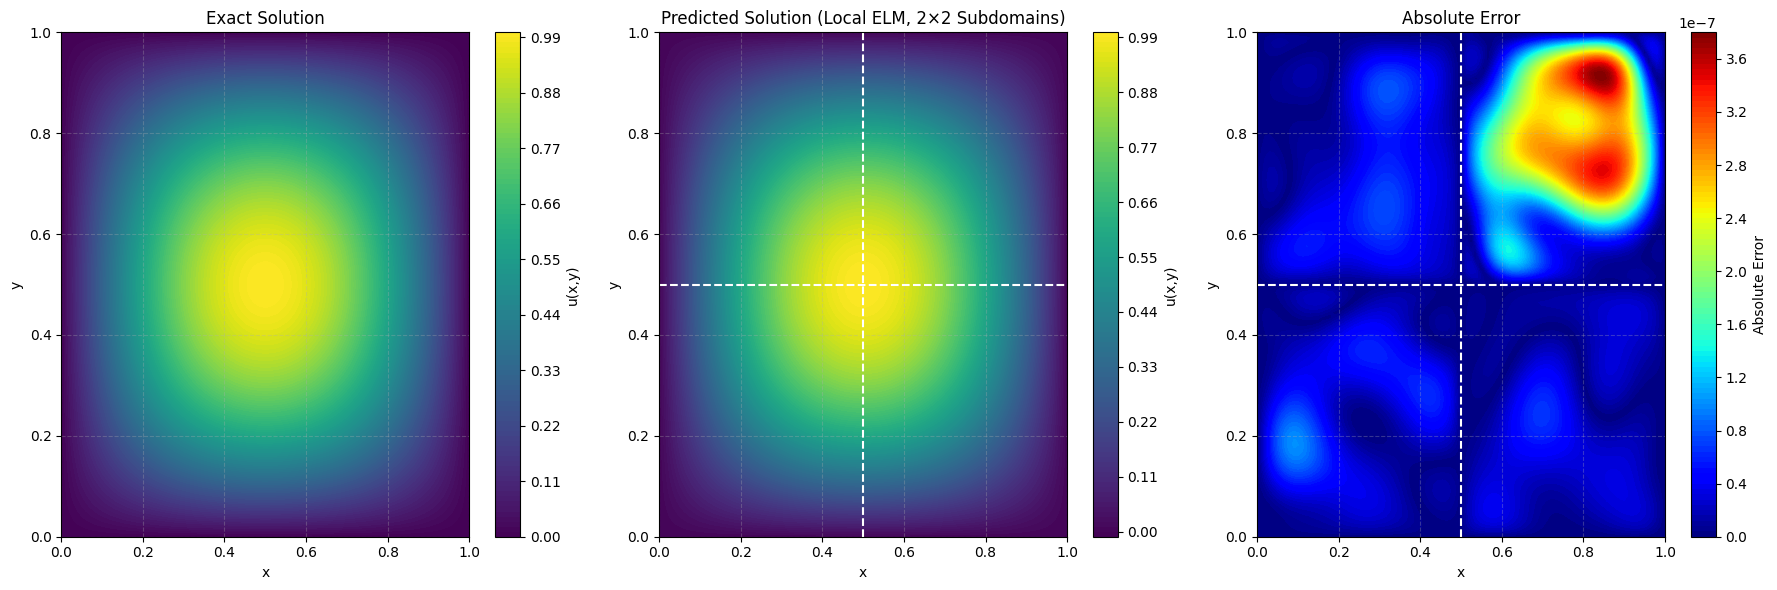

局部ELM求解器结果
子域划分：2×2
隐藏层节点数：300
测试网格：100×100
每个子域内部训练点：200
每条边边界点：100
最大误差：3.79e-07
RMS误差：9.33e-08
运行时间：0.5936秒


(3.7931730738349767e-07, 9.332743330153494e-08, 0.5935804843902588)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 设置全局随机种子，确保可复现性
np.random.seed(1224)

# 定义精确解u
def exact_solution(x, y):
    """精确解 u(x,y) = sin(πx)sin(πy)"""
    return np.sin(np.pi * x) * np.sin(np.pi * y)

# 定义源项f
def source_term(x, y):
    """泊松方程源项 f = -Δu = 2π² sin(πx)sin(πy)"""
    return 2 * np.pi**2 * exact_solution(x, y)

# 定义边界条件g
def boundary_condition(x, y):
    """边界条件 g = u|∂Ω"""
    return exact_solution(x, y)

# 网格生成
def generate_grid(nx, ny):
    """生成 nx×ny 均匀网格，返回：
    - X, Y: 二维网格坐标
    - X_flat, Y_flat: 扁平化坐标点
    - grid_points: 形状为 (nx*ny, 2) 的坐标矩阵
    """
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    X_flat, Y_flat = X.flatten(), Y.flatten()
    grid_points = np.column_stack((X_flat, Y_flat)) # 形状为 (nx*ny, 2)
    return X, Y, X_flat, Y_flat, grid_points

# 子域点生成
def generate_subdomain_points(subdomain, n_train, n_boundary_per_edge):
    """生成单个子域的训练点和边界点
    subdomain: (x_min, x_max, y_min, y_max)
    n_train: 内部训练点数量
    n_boundary_per_edge: 每条边的边界点数量
    """
    x_min, x_max, y_min, y_max = subdomain
    eps = 1e-3  # 避免边界的小扰动，确保内部点不落在边界上

    # 内部训练点：均匀随机采样
    x_train = np.random.uniform(x_min + eps, x_max - eps, n_train)
    y_train = np.random.uniform(y_min + eps, y_max - eps, n_train)
    train_points = np.column_stack((x_train, y_train))  # 形状为 (n_train, 2)
    
    # 边界点：四条边分别采样
    edges = [
        # (x采样, y采样)
        (np.full(n_boundary_per_edge, x_min), np.random.uniform(y_min, y_max, n_boundary_per_edge)),  # 左边界
        (np.full(n_boundary_per_edge, x_max), np.random.uniform(y_min, y_max, n_boundary_per_edge)),  # 右边界
        (np.random.uniform(x_min, x_max, n_boundary_per_edge), np.full(n_boundary_per_edge, y_min)),  # 下边界
        (np.random.uniform(x_min, x_max, n_boundary_per_edge), np.full(n_boundary_per_edge, y_max)),  # 上边界
    ]
    boundary_points = np.vstack([np.column_stack(edge) for edge in edges]) # 形状为 (4*n_boundary_per_edge, 2)
    
    return train_points, boundary_points

# 激活函数与导数计算
def sigmoid(z):
    """Sigmoid激活函数"""
    return 1 / (1 + np.exp(-z))

def compute_laplacian_sigmoid(x, y, w, b, h=1e-4):
    """向量化计算sigmoid隐藏层输出的拉普拉斯（二阶导数和）
    x, y: 输入坐标 (N,)
    w: 隐藏层权重 (2, M)
    b: 隐藏层偏置 (M,)
    h: 有限差分步长
    返回: 每个点每个隐藏节点的拉普拉斯值 (N, M)
    """
    N = len(x) # 输入点数量
    M = w.shape[1] # 隐藏层节点数
    
    # 中心差分计算二阶导数
    # u_xx = (u(x+h,y) - 2u(x,y) + u(x-h,y)) / h²
    z_center = x[:, None] * w[0, :] + y[:, None] * w[1, :] + b  # 中心点 (N, M)
    z_xp = (x + h)[:, None] * w[0, :] + y[:, None] * w[1, :] + b  # x+h 点 (N, M)
    z_xm = (x - h)[:, None] * w[0, :] + y[:, None] * w[1, :] + b  # x-h 点 (N, M)
    z_yp = x[:, None] * w[0, :] + (y + h)[:, None] * w[1, :] + b  # y+h 点 (N, M)
    z_ym = x[:, None] * w[0, :] + (y - h)[:, None] * w[1, :] + b  # y-h 点 (N, M)
    
    u_center = sigmoid(z_center) # (N, M)
    u_xx = (sigmoid(z_xp) - 2 * u_center + sigmoid(z_xm)) / h**2 # (N, M)
    u_yy = (sigmoid(z_yp) - 2 * u_center + sigmoid(z_ym)) / h**2 # (N, M)
    
    return u_xx + u_yy  # (N, M)

# 局部ELM求解器
def local_elm_poisson_solver(K, M, nx, ny, n_train_per_subdomain, n_boundary_per_edge):
    """局部ELM求解泊松方程（非重叠子域）"""
    start_time = time.time()
    
    # 生成测试网格
    X, Y, X_flat, Y_flat, test_points = generate_grid(nx, ny)
    n_test = len(test_points) # 测试点总数 = nx*ny
    
    # 子域划分
    dx = 1.0 / K
    dy = 1.0 / K
    subdomains = [
        (i*dx, (i+1)*dx, j*dy, (j+1)*dy)
        for i in range(K) for j in range(K)
    ] # 子域列表，每个元素是 (x_min, x_max, y_min, y_max)
    n_subdomains = len(subdomains)  # K*K 个子域
    
    # 生成子域训练数据
    subdomain_train_data = []  # 每个子域：(train_points, boundary_points)
    for subdomain in subdomains:
        train_points, boundary_points = generate_subdomain_points(
            subdomain, n_train_per_subdomain, n_boundary_per_edge
        )
        subdomain_train_data.append((train_points, boundary_points))
    
    # 训练每个子域的ELM模型 
    elm_models = []  # 每个模型：(w, b, beta)
    for k in range(n_subdomains):
        train_points, boundary_points = subdomain_train_data[k]
        n_train = len(train_points) # 内部点数量 = n_train_per_subdomain
        n_boundary = len(boundary_points) # 边界点数量 = 4*n_boundary_per_edge
        
        # 合并训练点和边界点
        all_points = np.vstack((train_points, boundary_points)) # (n_total, 2)
        n_total = n_train + n_boundary # 总点数量
        
        # 生成当前子域的随机参数（使用全局种子+子域索引，确保可复现性和随机性）
        local_seed = 1224 + k
        np.random.seed(local_seed)
        w = np.random.randn(2, M)  # 隐藏层权重 (2, M)
        b = np.random.randn(M)  # 隐藏层偏置 (M,)
        
        # 计算隐藏层输出矩阵 H (n_total, M)
        H = sigmoid(all_points @ w + b)
        
        # 构建目标向量 T 
        T = np.zeros(n_total)
        
        # 1. 内部点：拟合PDE残差 -Δu = f → Δu + f = 0
        x_train, y_train = train_points[:, 0], train_points[:, 1]
        # 计算每个内部点每个隐藏节点的拉普拉斯值 (n_train, M)
        laplacian_H_train = compute_laplacian_sigmoid(x_train, y_train, w, b)
        # 残差：Δu + f = (β·laplacian_H) + f = 0 → 目标值为 -f
        T[:n_train] = -source_term(x_train, y_train)
        
        # 2. 边界点：拟合边界条件 u = g → 目标值为 g
        x_bnd, y_bnd = boundary_points[:, 0], boundary_points[:, 1]
        T[n_train:] = boundary_condition(x_bnd, y_bnd)
        
        # 构建完整方程组 
        # 内部点方程：laplacian_H @ β = -f
        # 边界点方程：H_bnd @ β = g
        A = np.vstack([laplacian_H_train, H[n_train:, :]])  # (n_total, M)
        B = T  # (n_total,)
        
        # 求解 ELM 输出权重 beta
        beta = np.linalg.lstsq(A, B, rcond=None)[0]  # 使用最小二乘法求解 (M,)，[0]表示取解
        elm_models.append((w, b, beta))
    
    # 预测全局解（向量化优化）
    u_pred = np.zeros(n_test)
    # 为每个测试点分配子域索引
    subdomain_indices = np.zeros(n_test, dtype=int)
    for i, (x, y) in enumerate(test_points):
        for k, (x_min, x_max, y_min, y_max) in enumerate(subdomains):
            if x_min <= x <= x_max and y_min <= y <= y_max:
                subdomain_indices[i] = k
                break
    
    # 按子域批量预测
    for k in range(n_subdomains):
        # 获取当前子域的测试点索引
        idx = np.where(subdomain_indices == k)[0] # 测试点索引
        if len(idx) == 0:
            continue
        # 获取当前子域的模型参数
        w, b, beta = elm_models[k]
        # 批量计算隐藏层输出并预测
        z = test_points[idx] @ w + b  # (n_sub_test, M)
        H_test = sigmoid(z)  # (n_sub_test, M)
        u_pred[idx] = H_test @ beta  # (n_sub_test,)
    
    # 计算误差
    u_exact = exact_solution(X_flat, Y_flat)
    error = np.abs(u_pred - u_exact)
    max_error = np.max(error)
    rms_error = np.sqrt(np.mean(error**2))
    run_time = time.time() - start_time
    
    # 可视化结果
    plt.figure(figsize=(18, 6))
    
    # 1. 精确解
    plt.subplot(131)
    contour_exact = plt.contourf(X, Y, u_exact.reshape(nx, ny), 100, cmap='viridis')
    plt.colorbar(contour_exact, label='u(x,y)')
    plt.title('Exact Solution')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 2. 预测解
    plt.subplot(132)
    contour_pred = plt.contourf(X, Y, u_pred.reshape(nx, ny), 100, cmap='viridis')
    plt.colorbar(contour_pred, label='u(x,y)')
    # 绘制子域边界
    for i in range(1, K):
        plt.axvline(i*dx, color='white', linestyle='--', linewidth=1.5)
        plt.axhline(i*dy, color='white', linestyle='--', linewidth=1.5)
    plt.title(f'Predicted Solution (Local ELM, {K}×{K} Subdomains)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 3. 绝对误差
    plt.subplot(133)
    contour_error = plt.contourf(X, Y, error.reshape(nx, ny), 100, cmap='jet')
    plt.colorbar(contour_error, label='Absolute Error')
    # 绘制子域边界
    for i in range(1, K):
        plt.axvline(i*dx, color='white', linestyle='--', linewidth=1.5)
        plt.axhline(i*dy, color='white', linestyle='--', linewidth=1.5)
    plt.title('Absolute Error')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 输出结果 
    print("="*60)
    print("局部ELM求解器结果")
    print("="*60)
    print(f"子域划分：{K}×{K}")
    print(f"隐藏层节点数：{M}")
    print(f"测试网格：{nx}×{ny}")
    print(f"每个子域内部训练点：{n_train_per_subdomain}")
    print(f"每条边边界点：{n_boundary_per_edge}")
    print(f"最大误差：{max_error:.2e}")
    print(f"RMS误差：{rms_error:.2e}")
    print(f"运行时间：{run_time:.4f}秒")
    print("="*60)
    
    return max_error, rms_error, run_time

# 运行局部ELM求解器
# 设定参数
K = 2  # 子域划分：K×K
M = 300  # 每个ELM的隐藏层节点数
nx, ny = 100, 100  # 测试网格分辨率
n_train_per_subdomain = 200  # 每个子域内部训练点数量
n_boundary_per_edge = 100  # 每条边的边界点数量
local_elm_poisson_solver(K, M, nx, ny, n_train_per_subdomain, n_boundary_per_edge)


实验1：不同 λ 对收敛性的影响

测试 λ = 0.1
迭代 1/50
  RMS误差: 1.738646e-01
迭代 2/50
  RMS误差: 6.609852e-02
迭代 3/50
  RMS误差: 2.525064e-02
迭代 4/50
  RMS误差: 9.782534e-03
迭代 5/50
  RMS误差: 3.765098e-03
迭代 6/50
  RMS误差: 1.476670e-03
迭代 7/50
  RMS误差: 6.255042e-04
迭代 8/50
  RMS误差: 3.444994e-04
迭代 9/50
  RMS误差: 2.997142e-04
迭代 10/50
  RMS误差: 2.414278e-04
迭代 11/50
  RMS误差: 2.796746e-04
迭代 12/50
  RMS误差: 2.022844e-04
迭代 13/50
  RMS误差: 2.204190e-04
迭代 14/50
  RMS误差: 3.079335e-04
迭代 15/50
  RMS误差: 2.114664e-04
迭代 16/50
  RMS误差: 2.786248e-04
迭代 17/50
  RMS误差: 3.032311e-04
迭代 18/50
  RMS误差: 1.882541e-04
迭代 19/50
  RMS误差: 2.793350e-04
迭代 20/50
  RMS误差: 2.753384e-04
迭代 21/50
  RMS误差: 1.707950e-04
迭代 22/50
  RMS误差: 2.482370e-04
迭代 23/50
  RMS误差: 3.471736e-04
迭代 24/50
  RMS误差: 3.255392e-04
迭代 25/50
  RMS误差: 2.273337e-04
迭代 26/50
  RMS误差: 1.908413e-04
迭代 27/50
  RMS误差: 2.160926e-04
迭代 28/50
  RMS误差: 5.224226e-04
迭代 29/50
  RMS误差: 2.553660e-04
迭代 30/50
  RMS误差: 2.279150e-04
迭代 31/50
  RMS误差: 2.496904e-04
迭代 32/50
  RMS误差: 

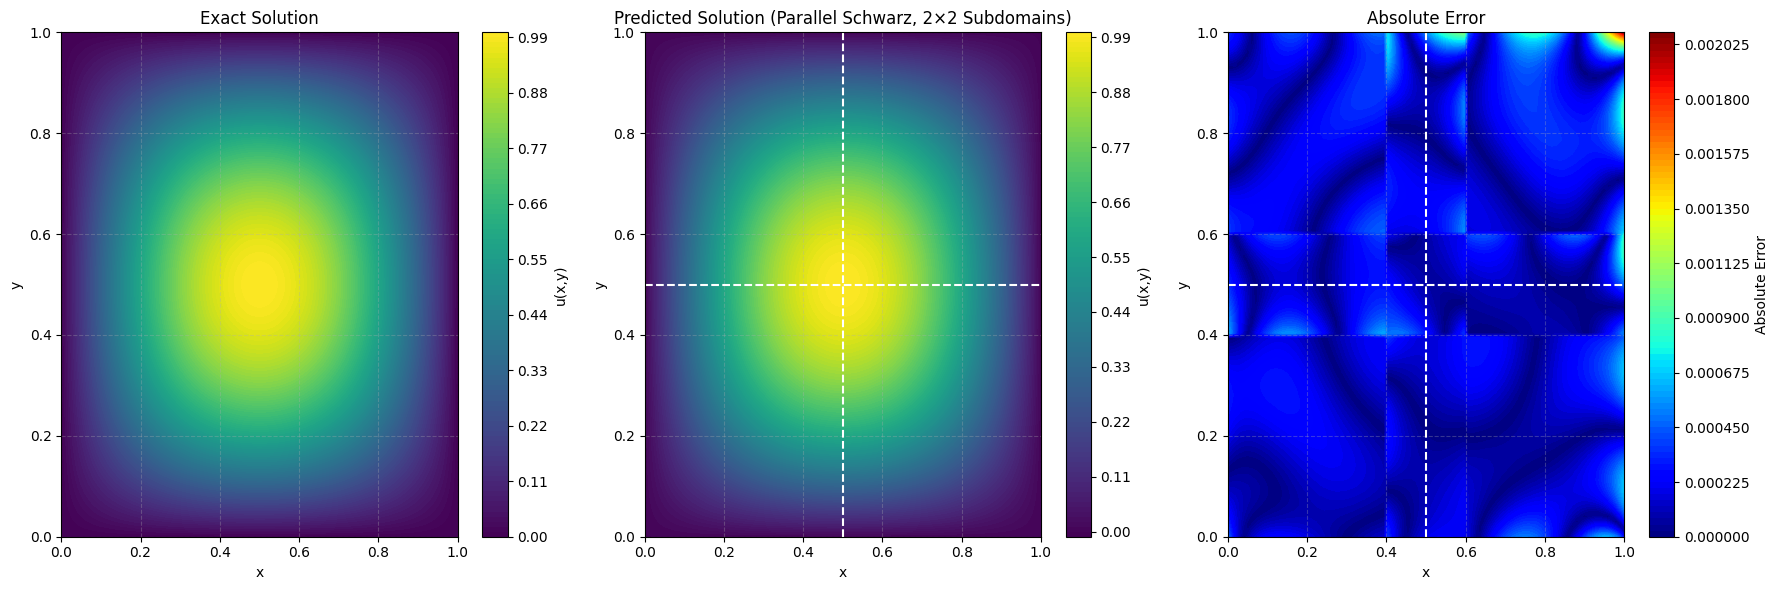

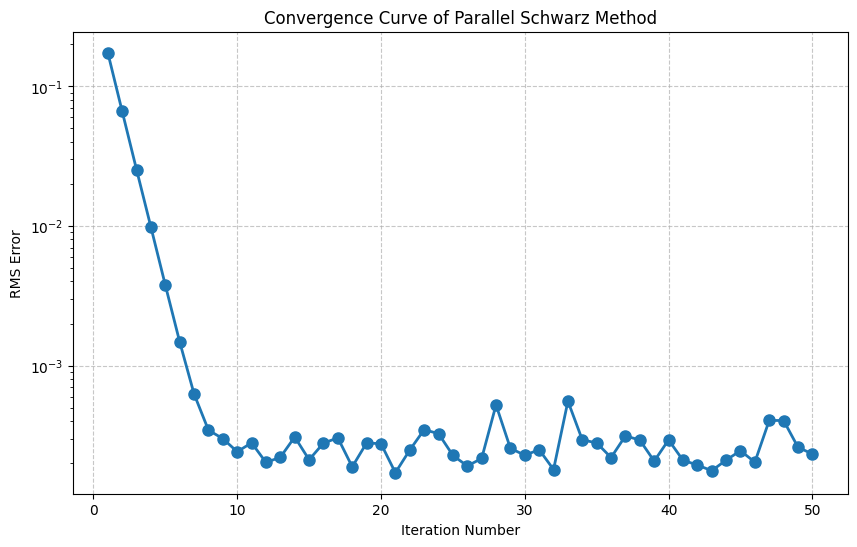

并行施瓦茨ELM求解器结果
子域划分：2×2
重叠率：20.0%
隐藏层节点数：300
测试网格：100×100
迭代次数：50
最终RMS误差：2.33e-04
运行时间：69.2260秒

测试 λ = 1.0
迭代 1/50
  RMS误差: 3.053506e-01
迭代 2/50
  RMS误差: 2.107249e-01
迭代 3/50
  RMS误差: 1.473463e-01
迭代 4/50
  RMS误差: 1.056318e-01
迭代 5/50
  RMS误差: 7.514128e-02
迭代 6/50
  RMS误差: 5.329381e-02
迭代 7/50
  RMS误差: 3.797856e-02
迭代 8/50
  RMS误差: 2.692108e-02
迭代 9/50
  RMS误差: 1.932679e-02
迭代 10/50
  RMS误差: 1.387377e-02
迭代 11/50
  RMS误差: 9.789759e-03
迭代 12/50
  RMS误差: 6.976894e-03
迭代 13/50
  RMS误差: 5.019459e-03
迭代 14/50
  RMS误差: 3.563881e-03
迭代 15/50
  RMS误差: 2.510483e-03
迭代 16/50
  RMS误差: 1.794873e-03
迭代 17/50
  RMS误差: 1.329055e-03
迭代 18/50
  RMS误差: 9.508338e-04
迭代 19/50
  RMS误差: 7.141784e-04
迭代 20/50
  RMS误差: 5.543611e-04
迭代 21/50
  RMS误差: 4.064068e-04
迭代 22/50
  RMS误差: 3.641488e-04
迭代 23/50
  RMS误差: 4.269552e-04
迭代 24/50
  RMS误差: 3.789488e-04
迭代 25/50
  RMS误差: 2.580963e-04
迭代 26/50
  RMS误差: 2.084806e-04
迭代 27/50
  RMS误差: 2.172019e-04
迭代 28/50
  RMS误差: 5.553434e-04
迭代 29/50
  RMS误差: 2.575271e-04
迭代

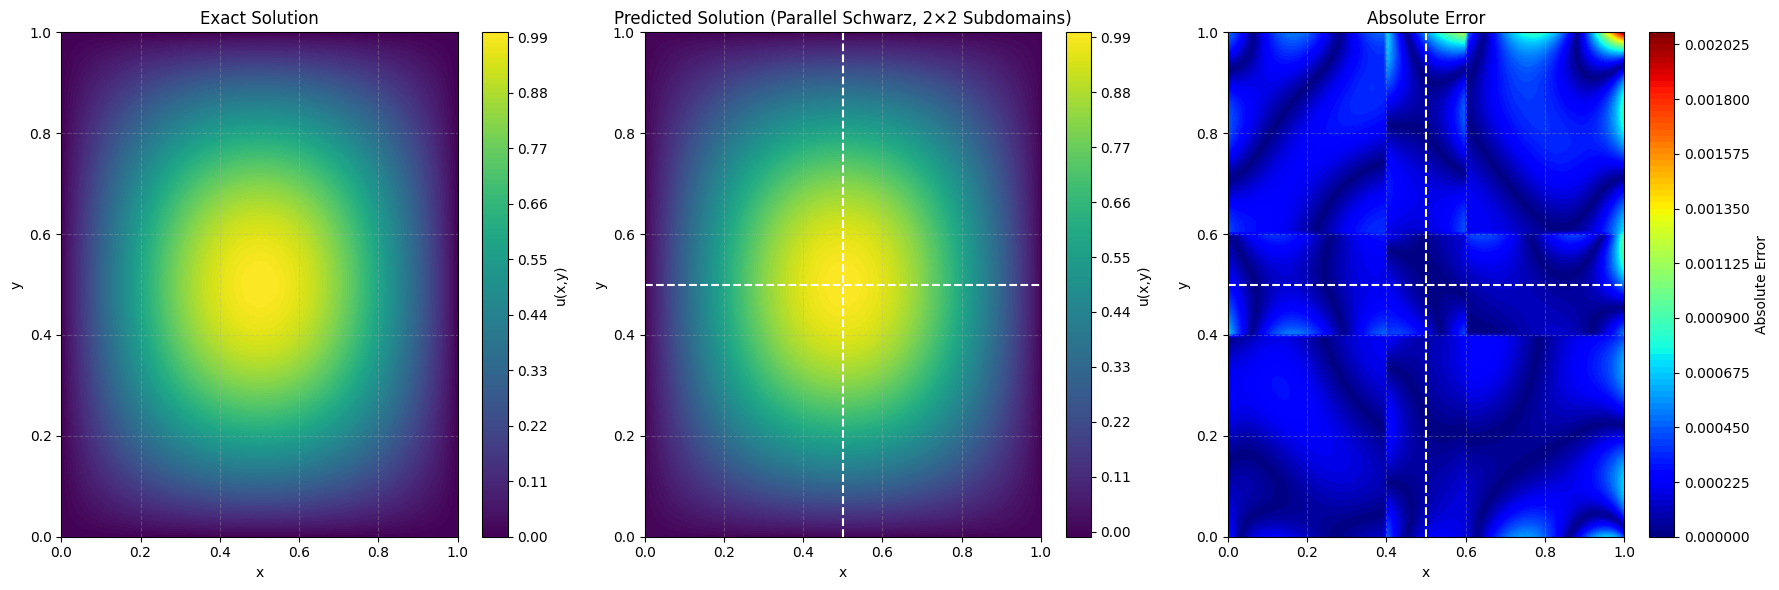

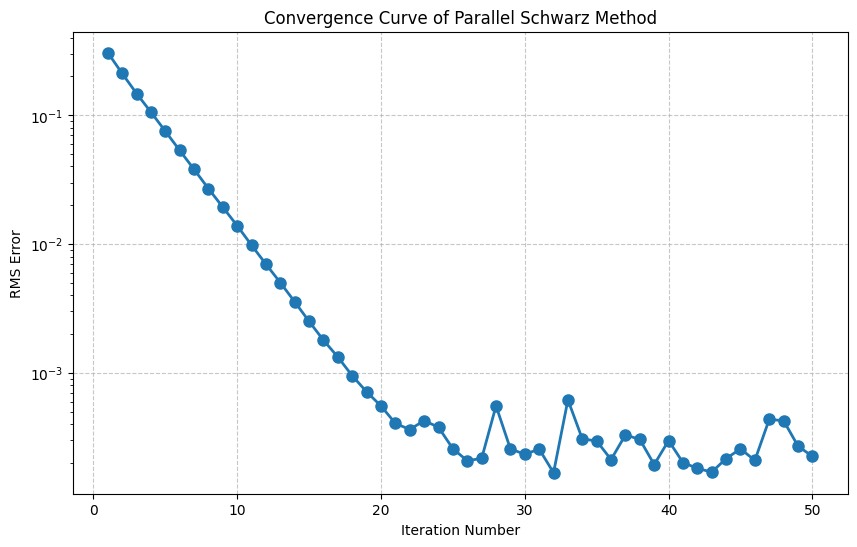

并行施瓦茨ELM求解器结果
子域划分：2×2
重叠率：20.0%
隐藏层节点数：300
测试网格：100×100
迭代次数：50
最终RMS误差：2.25e-04
运行时间：55.5749秒

测试 λ = 10.0
迭代 1/50
  RMS误差: 4.219684e-01
迭代 2/50
  RMS误差: 3.948885e-01
迭代 3/50
  RMS误差: 3.714728e-01
迭代 4/50
  RMS误差: 3.551442e-01
迭代 5/50
  RMS误差: 3.371543e-01
迭代 6/50
  RMS误差: 3.200229e-01
迭代 7/50
  RMS误差: 3.043913e-01
迭代 8/50
  RMS误差: 2.889592e-01
迭代 9/50
  RMS误差: 2.751169e-01
迭代 10/50
  RMS误差: 2.611840e-01
迭代 11/50
  RMS误差: 2.467815e-01
迭代 12/50
  RMS误差: 2.335570e-01
迭代 13/50
  RMS误差: 2.224879e-01
迭代 14/50
  RMS误差: 2.115522e-01
迭代 15/50
  RMS误差: 2.009983e-01
迭代 16/50
  RMS误差: 1.908009e-01
迭代 17/50
  RMS误差: 1.803248e-01
迭代 18/50
  RMS误差: 1.715895e-01
迭代 19/50
  RMS误差: 1.631518e-01
迭代 20/50
  RMS误差: 1.542322e-01
迭代 21/50
  RMS误差: 1.477326e-01
迭代 22/50
  RMS误差: 1.398832e-01
迭代 23/50
  RMS误差: 1.331620e-01
迭代 24/50
  RMS误差: 1.260879e-01
迭代 25/50
  RMS误差: 1.198407e-01
迭代 26/50
  RMS误差: 1.135168e-01
迭代 27/50
  RMS误差: 1.080640e-01
迭代 28/50
  RMS误差: 1.018111e-01
迭代 29/50
  RMS误差: 9.725844e-02
迭

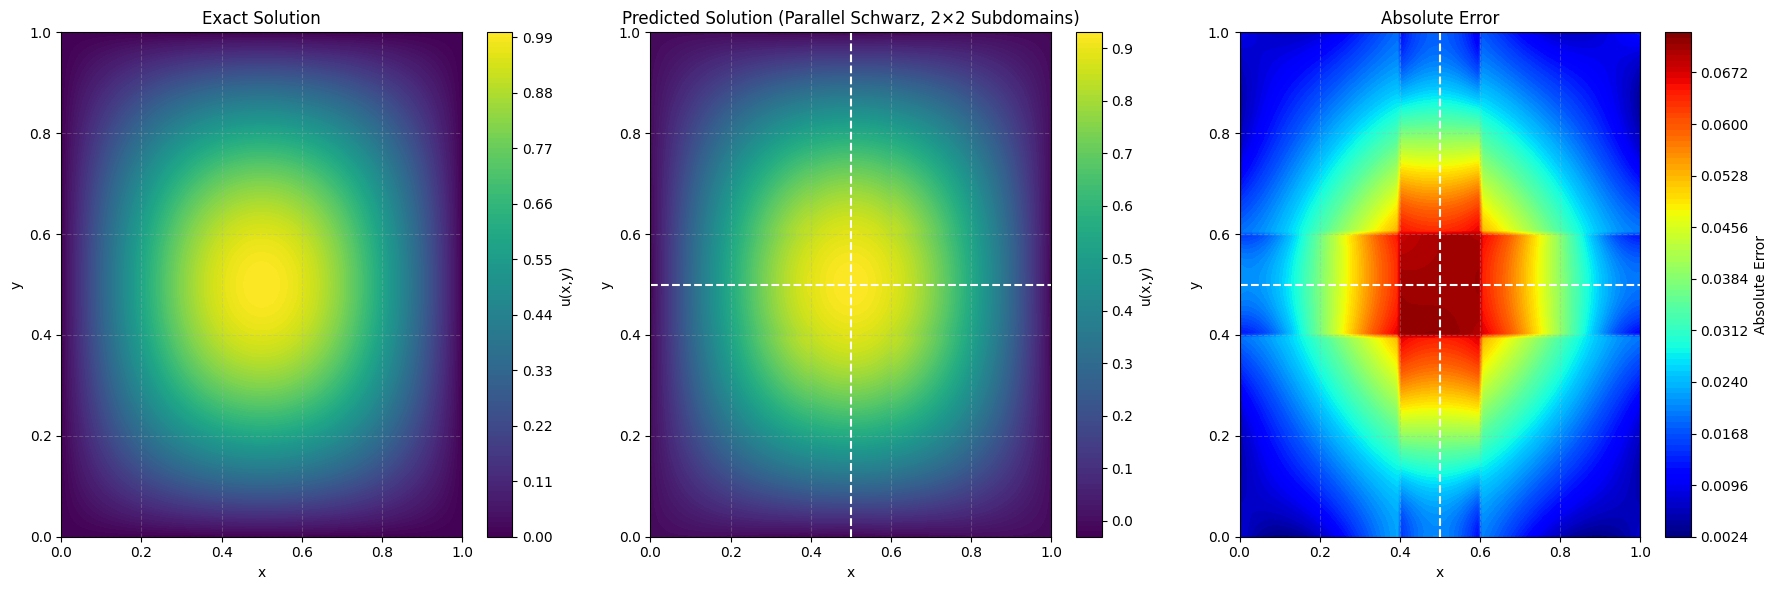

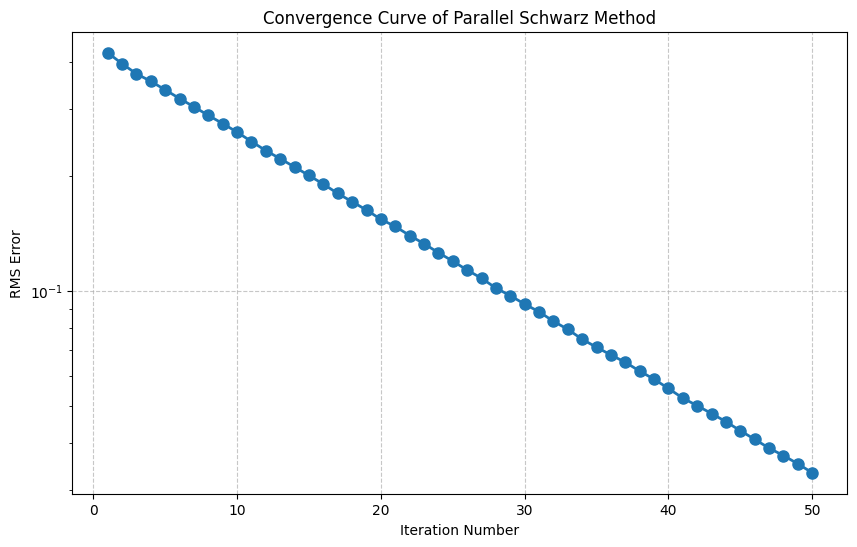

并行施瓦茨ELM求解器结果
子域划分：2×2
重叠率：20.0%
隐藏层节点数：300
测试网格：100×100
迭代次数：50
最终RMS误差：3.34e-02
运行时间：59.6977秒


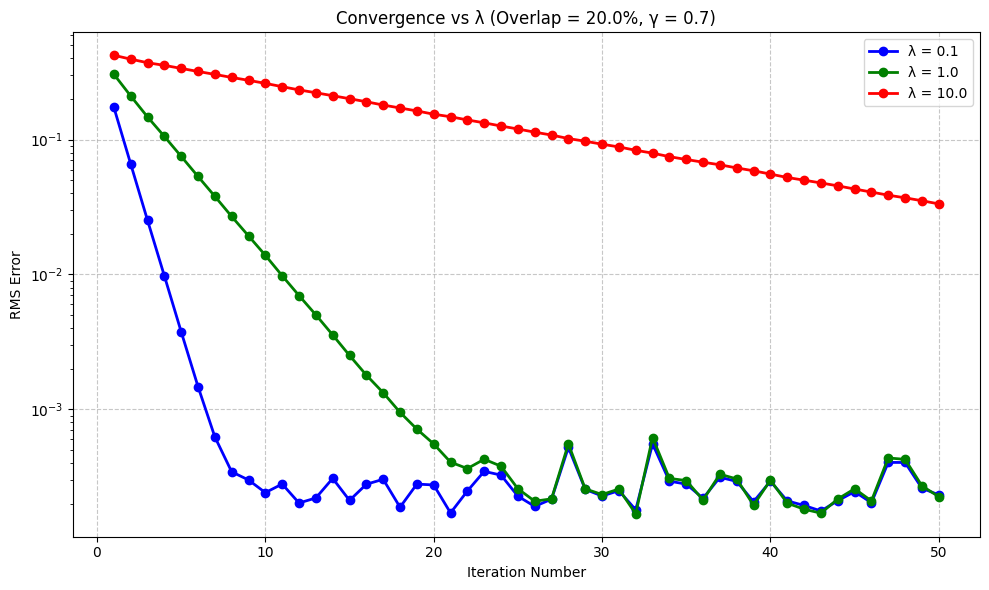


实验2：不同重叠率对收敛性的影响

测试 重叠率 = 10.0%
迭代 1/50
  RMS误差: 2.941705e-01
迭代 2/50
  RMS误差: 2.006432e-01
迭代 3/50
  RMS误差: 1.409052e-01
迭代 4/50
  RMS误差: 1.021555e-01
迭代 5/50
  RMS误差: 7.541272e-02
迭代 6/50
  RMS误差: 5.552081e-02
迭代 7/50
  RMS误差: 4.171898e-02
迭代 8/50
  RMS误差: 3.109760e-02
迭代 9/50
  RMS误差: 2.376060e-02
迭代 10/50
  RMS误差: 1.802592e-02
迭代 11/50
  RMS误差: 1.336769e-02
迭代 12/50
  RMS误差: 1.023072e-02
迭代 13/50
  RMS误差: 7.830038e-03
迭代 14/50
  RMS误差: 5.890034e-03
迭代 15/50
  RMS误差: 4.483814e-03
迭代 16/50
  RMS误差: 3.397172e-03
迭代 17/50
  RMS误差: 2.607399e-03
迭代 18/50
  RMS误差: 2.073851e-03
迭代 19/50
  RMS误差: 1.579159e-03
迭代 20/50
  RMS误差: 1.239121e-03
迭代 21/50
  RMS误差: 9.530651e-04
迭代 22/50
  RMS误差: 7.393693e-04
迭代 23/50
  RMS误差: 5.998098e-04
迭代 24/50
  RMS误差: 4.881955e-04
迭代 25/50
  RMS误差: 3.802048e-04
迭代 26/50
  RMS误差: 2.938344e-04
迭代 27/50
  RMS误差: 2.550686e-04
迭代 28/50
  RMS误差: 3.794447e-04
迭代 29/50
  RMS误差: 2.068803e-04
迭代 30/50
  RMS误差: 1.843705e-04
迭代 31/50
  RMS误差: 1.705680e-04
迭代 32/50
  RMS

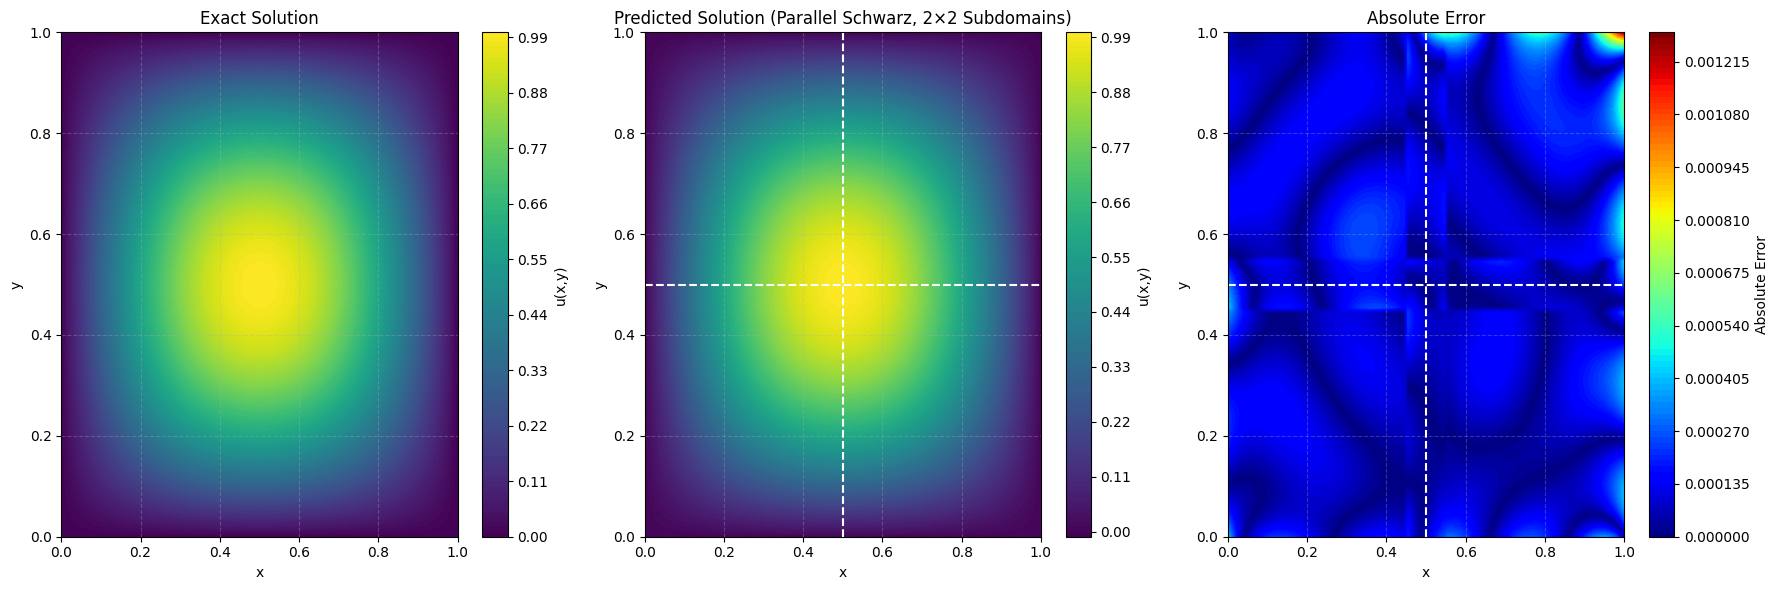

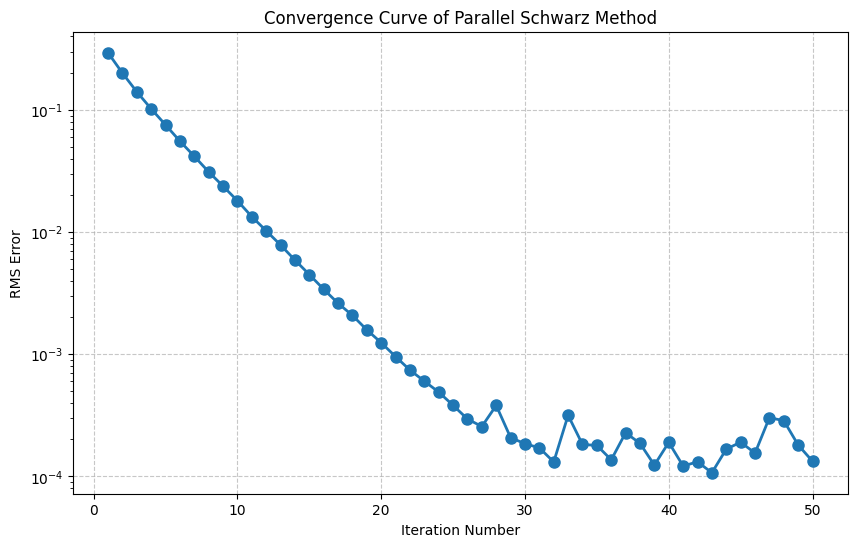

并行施瓦茨ELM求解器结果
子域划分：2×2
重叠率：10.0%
隐藏层节点数：300
测试网格：100×100
迭代次数：50
最终RMS误差：1.32e-04
运行时间：54.9082秒

测试 重叠率 = 20.0%
迭代 1/50
  RMS误差: 3.053506e-01
迭代 2/50
  RMS误差: 2.107249e-01
迭代 3/50
  RMS误差: 1.473463e-01
迭代 4/50
  RMS误差: 1.056318e-01
迭代 5/50
  RMS误差: 7.514128e-02
迭代 6/50
  RMS误差: 5.329381e-02
迭代 7/50
  RMS误差: 3.797856e-02
迭代 8/50
  RMS误差: 2.692108e-02
迭代 9/50
  RMS误差: 1.932679e-02
迭代 10/50
  RMS误差: 1.387377e-02
迭代 11/50
  RMS误差: 9.789759e-03
迭代 12/50
  RMS误差: 6.976894e-03
迭代 13/50
  RMS误差: 5.019459e-03
迭代 14/50
  RMS误差: 3.563881e-03
迭代 15/50
  RMS误差: 2.510483e-03
迭代 16/50
  RMS误差: 1.794873e-03
迭代 17/50
  RMS误差: 1.329055e-03
迭代 18/50
  RMS误差: 9.508338e-04
迭代 19/50
  RMS误差: 7.141784e-04
迭代 20/50
  RMS误差: 5.543611e-04
迭代 21/50
  RMS误差: 4.064068e-04
迭代 22/50
  RMS误差: 3.641488e-04
迭代 23/50
  RMS误差: 4.269552e-04
迭代 24/50
  RMS误差: 3.789488e-04
迭代 25/50
  RMS误差: 2.580963e-04
迭代 26/50
  RMS误差: 2.084806e-04
迭代 27/50
  RMS误差: 2.172019e-04
迭代 28/50
  RMS误差: 5.553434e-04
迭代 29/50
  RMS误差: 2.575271e-0

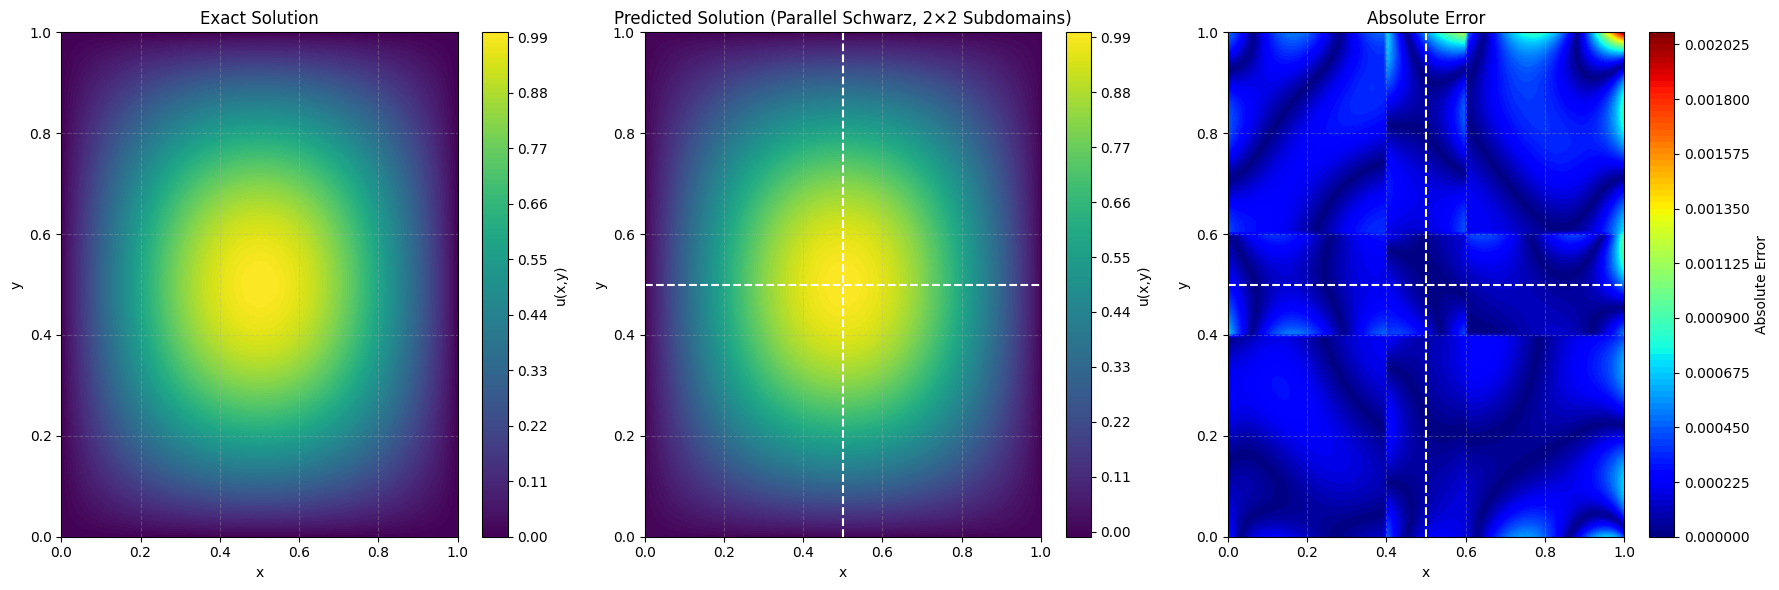

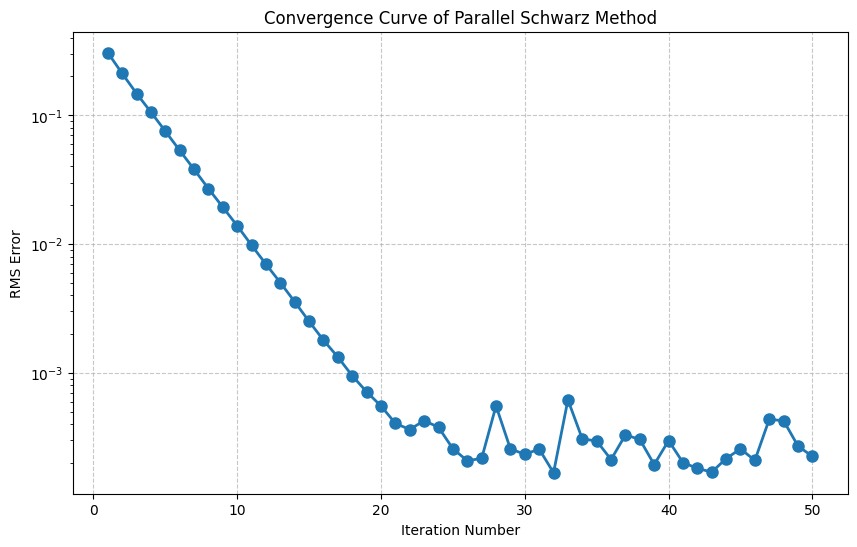

并行施瓦茨ELM求解器结果
子域划分：2×2
重叠率：20.0%
隐藏层节点数：300
测试网格：100×100
迭代次数：50
最终RMS误差：2.25e-04
运行时间：64.7038秒

测试 重叠率 = 30.0%
迭代 1/50
  RMS误差: 3.107238e-01
迭代 2/50
  RMS误差: 2.136893e-01
迭代 3/50
  RMS误差: 1.472868e-01
迭代 4/50
  RMS误差: 1.033216e-01
迭代 5/50
  RMS误差: 7.141295e-02
迭代 6/50
  RMS误差: 4.946523e-02
迭代 7/50
  RMS误差: 3.412135e-02
迭代 8/50
  RMS误差: 2.358061e-02
迭代 9/50
  RMS误差: 1.631480e-02
迭代 10/50
  RMS误差: 1.132645e-02
迭代 11/50
  RMS误差: 7.775391e-03
迭代 12/50
  RMS误差: 5.316511e-03
迭代 13/50
  RMS误差: 3.711358e-03
迭代 14/50
  RMS误差: 2.576942e-03
迭代 15/50
  RMS误差: 1.750772e-03
迭代 16/50
  RMS误差: 1.226827e-03
迭代 17/50
  RMS误差: 9.506558e-04
迭代 18/50
  RMS误差: 6.309824e-04
迭代 19/50
  RMS误差: 5.727472e-04
迭代 20/50
  RMS误差: 5.086995e-04
迭代 21/50
  RMS误差: 3.482808e-04
迭代 22/50
  RMS误差: 4.358576e-04
迭代 23/50
  RMS误差: 6.060515e-04
迭代 24/50
  RMS误差: 5.315811e-04
迭代 25/50
  RMS误差: 3.563505e-04
迭代 26/50
  RMS误差: 2.955546e-04
迭代 27/50
  RMS误差: 3.709486e-04
迭代 28/50
  RMS误差: 7.955969e-04
迭代 29/50
  RMS误差: 3.950182e-0

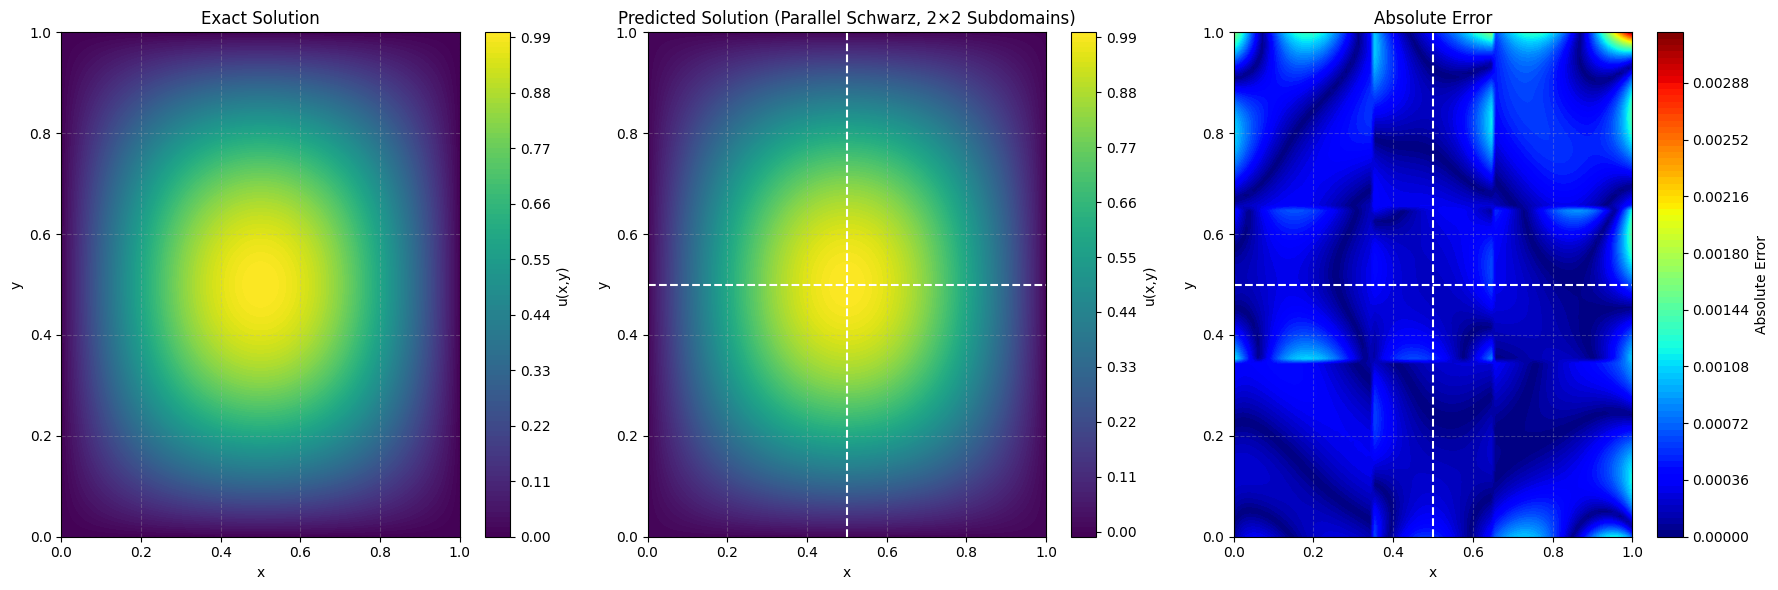

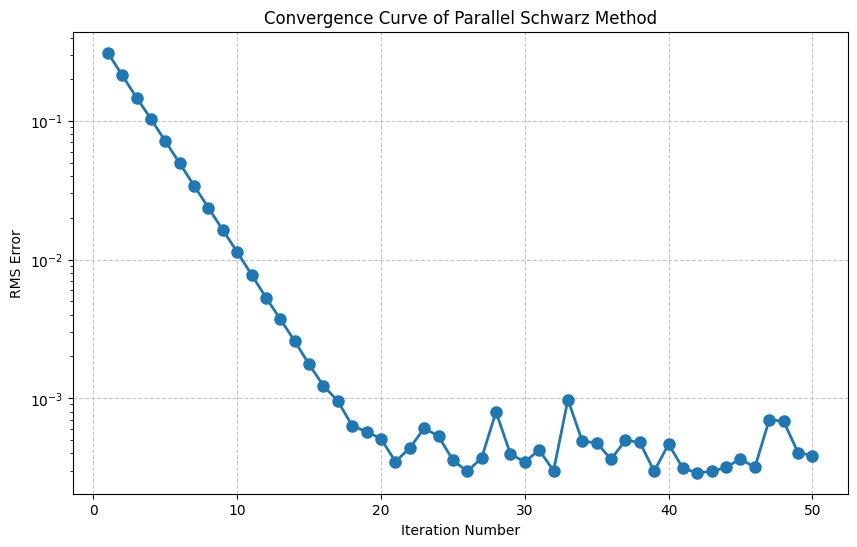

并行施瓦茨ELM求解器结果
子域划分：2×2
重叠率：30.0%
隐藏层节点数：300
测试网格：100×100
迭代次数：50
最终RMS误差：3.85e-04
运行时间：65.7599秒


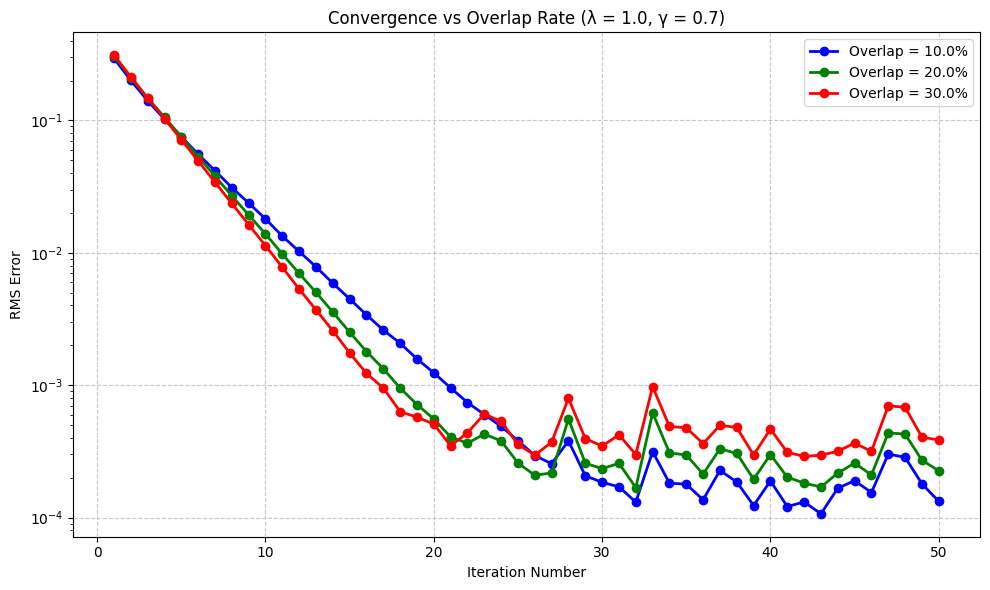

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import RegularGridInterpolator
import warnings
warnings.filterwarnings("ignore") # 忽略警告信息

# 设置全局随机种子，确保可复现性
np.random.seed(1224)

# 定义精确解u
def exact_solution(x, y):
    """精确解 u(x,y) = sin(πx)sin(πy)"""
    return np.sin(np.pi * x) * np.sin(np.pi * y)

# 定义源项f
def source_term(x, y):
    """泊松方程源项 f = -Δu = 2π² sin(πx)sin(πy)"""
    return 2 * np.pi**2 * exact_solution(x, y)

# 定义边界条件g
def boundary_condition(x, y):
    """边界条件 g = u|∂Ω"""
    return exact_solution(x, y)

# 网格生成
def generate_grid(nx, ny):
    """生成 nx×ny 均匀网格，返回：
    - X, Y: 二维网格坐标
    - X_flat, Y_flat: 扁平化坐标点
    - grid_points: 形状为 (nx*ny, 2) 的坐标矩阵
    """
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    X_flat, Y_flat = X.flatten(), Y.flatten()
    grid_points = np.column_stack((X_flat, Y_flat)) # 形状为 (nx*ny, 2)
    return X, Y, X_flat, Y_flat, grid_points

# Sigmoid激活函数
def sigmoid(z):
    """Sigmoid激活函数"""
    # 防止溢出
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

# 解析拉普拉斯算子
def compute_laplacian_sigmoid_analytic(x, y, w, b):
    """
    解析计算每个隐藏单元的拉普拉斯 Δσ(w·[x,y] + b)
    返回: (N, M)
    """
    N = len(x)
    M = w.shape[1]
    # z = x*w1 + y*w2 + b -> (N, M)
    z = x[:, None] * w[0, :] + y[:, None] * w[1, :] + b
    sigma = sigmoid(z)
    sigma_prime = sigma * (1 - sigma)
    sigma_double_prime = sigma_prime * (1 - 2 * sigma)
    laplacian = (w[0, :]**2 + w[1, :]**2) * sigma_double_prime  # (N, M)
    return laplacian

# 生成重叠子域
def generate_overlapping_subdomains(K, overlap_rate):
    """生成K×K个重叠子域
    K: 子域数量（K×K）
    overlap_rate: 重叠率（0-1）
    返回: 子域列表，每个元素是 (x_min, x_max, y_min, y_max)
    """
    dx = 1.0 / K  # 基础子域宽度
    overlap = dx * overlap_rate  # 重叠宽度
    
    subdomains = []
    for i in range(K):
        for j in range(K):
            # 计算子域边界，考虑重叠
            x0 = max(0, i*dx - overlap)
            x1 = min(1, (i+1)*dx + overlap)
            y0 = max(0, j*dx - overlap)
            y1 = min(1, (j+1)*dx + overlap)
            subdomains.append((x0, x1, y0, y1))
    return subdomains

# 生成子域训练数据（残差点+边界点+重叠区域点）
def generate_subdomain_data(subdomain, n_train, n_boundary_per_edge, neighbor_subdomains, neighbor_solutions, X_global, Y_global):
    """生成单个子域的训练点和边界点
    subdomain: (x_min, x_max, y_min, y_max)
    n_train: 内部训练点数量
    n_boundary_per_edge: 每条边的边界点数量
    neighbor_subdomains: 相邻子域列表，维度为(num_neighbors, 4)
    neighbor_solutions: 相邻子域的当前解（用于重叠区域约束），维度为(num_neighbors, nx, ny)或None
    X_global: 全局网格坐标（用于插值）
    Y_global: 全局网格坐标（用于插值）
    返回: 
        train_points: 内部训练点 (n_train, 2)
        boundary_points: 边界点 (4*n_boundary_per_edge, 2)
        overlap_points: 重叠区域点 (n_overlap, 2)
        overlap_targets: 重叠区域目标值 (n_overlap,)（若neighbor_solutions不为None）
    """
    x_min, x_max, y_min, y_max = subdomain
    eps = 1e-3  # 避免边界的小扰动，确保内部点不落在边界上

    # 内部训练点：均匀随机采样
    x_train = np.random.uniform(x_min + eps, x_max - eps, n_train)
    y_train = np.random.uniform(y_min + eps, y_max - eps, n_train)
    train_points = np.column_stack((x_train, y_train))  # 形状为 (n_train, 2)
    
    # 边界点：四条边分别采样
    edges = [
        # (x采样, y采样)
        (np.full(n_boundary_per_edge, x_min), np.random.uniform(y_min, y_max, n_boundary_per_edge)),  # 左边界
        (np.full(n_boundary_per_edge, x_max), np.random.uniform(y_min, y_max, n_boundary_per_edge)),  # 右边界
        (np.random.uniform(x_min, x_max, n_boundary_per_edge), np.full(n_boundary_per_edge, y_min)),  # 下边界
        (np.random.uniform(x_min, x_max, n_boundary_per_edge), np.full(n_boundary_per_edge, y_max)),  # 上边界
    ]
    boundary_points = np.vstack([np.column_stack(edge) for edge in edges]) # 形状为 (4*n_boundary_per_edge, 2)
    
    # 重叠区域点：从相邻子域的重叠部分采样
    overlap_points = [] # 重叠区域采样点
    overlap_targets = [] # 重叠区域目标值
    
    if neighbor_solutions is not None and len(neighbor_solutions) > 0:
        n_overlap = n_train // 2
        ny, nx = X_global.shape
        x_vals = np.linspace(0, 1, nx)
        y_vals = np.linspace(0, 1, ny)

        for neighbor_sub, neighbor_sol in zip(neighbor_subdomains, neighbor_solutions):
            # 计算重叠区域
            x_overlap_min = max(x_min, neighbor_sub[0])
            x_overlap_max = min(x_max, neighbor_sub[1])
            y_overlap_min = max(y_min, neighbor_sub[2])
            y_overlap_max = min(y_max, neighbor_sub[3])

            if x_overlap_min < x_overlap_max and y_overlap_min < y_overlap_max:
                x_overlap = np.random.uniform(x_overlap_min, x_overlap_max, n_overlap)
                y_overlap = np.random.uniform(y_overlap_min, y_overlap_max, n_overlap)
                points_ol = np.column_stack((x_overlap, y_overlap))
                overlap_points.append(points_ol)

                # 双线性插值
                interp = RegularGridInterpolator(
                    (y_vals, x_vals), neighbor_sol,
                    method='cubic', bounds_error=False, fill_value=0.0
                )
                targets = interp(np.column_stack((y_overlap, x_overlap)))
                overlap_targets.append(targets)

        if overlap_points:
            overlap_points = np.vstack(overlap_points)
            overlap_targets = np.concatenate(overlap_targets)
        else:
            overlap_points = np.empty((0, 2))
            overlap_targets = np.empty(0)
    else:
        overlap_points = np.empty((0, 2))
        overlap_targets = np.empty(0)

    return train_points, boundary_points, overlap_points, overlap_targets

# 训练单个子域的模型（并行执行）
def train_single_subdomain(args):
    """训练单个子域的模型
    args: 包含以下参数的元组
        k: 子域索引
        subdomain: 子域边界
        neighbor_subdomains: 相邻子域列表
        neighbor_solutions: 相邻子域的当前解
        M: 隐藏层节点数
        lambd: 施瓦茨约束正则化参数
        n_train_per_subdomain: 每个子域内部训练点数量
        n_boundary_per_edge: 每条边的边界点数量
        local_seed: 随机种子
        X_global: 全局网格坐标
        Y_global: 全局网格坐标
    返回: 
        k: 子域索引
        w: 隐藏层权重
        b: 隐藏层偏置
        beta: 输出层权重
    """
    (k, subdomain, neighbor_subdomains, neighbor_solutions,
     M, lambd, n_train_per_subdomain, n_boundary_per_edge,
     local_seed, X_global, Y_global) = args
    
    # 设置随机种子
    np.random.seed(local_seed)
    
    # 生成子域训练数据
    train_points, boundary_points, overlap_points, overlap_targets = generate_subdomain_data(
        subdomain, n_train_per_subdomain, n_boundary_per_edge, neighbor_subdomains, neighbor_solutions, X_global, Y_global
    )

    n_train = len(train_points) # 内部点数量 = n_train_per_subdomain
    n_boundary = len(boundary_points) # 边界点数量 = 4*n_boundary_per_edge
    n_overlap = len(overlap_points) # 重叠区域点数量 = len(overlap_points)
    
    # 合并所有训练点
    if n_overlap > 0:
        all_points = np.vstack([train_points, boundary_points, overlap_points])
    else:
        all_points = np.vstack([train_points, boundary_points])
    n_total = len(all_points) # 总点数量
    
    # 生成隐藏层参数
    w = np.random.randn(2, M) / np.sqrt(M)  # Xavier初始化
    b = np.random.randn(M) * 0.1            # 小幅度偏置初始化
    
    # 计算隐藏层输出
    H = sigmoid(all_points @ w + b)
    
    # 计算拉普拉斯隐藏层输出（仅用于内部点）
    laplacian_H_train = compute_laplacian_sigmoid_analytic(train_points[:, 0], train_points[:, 1], w, b)
    
    # 构建目标向量 T
    T = np.zeros(n_total)
    
    # 1. 内部点：拟合PDE残差 -Δu = f → Δu + f = 0
    T[:n_train] = -source_term(train_points[:, 0], train_points[:, 1])
    
    # 2. 边界点：拟合边界条件 u = g
    T[n_train:n_train+n_boundary] = boundary_condition(boundary_points[:, 0], boundary_points[:, 1])
    
    # 构建最小二乘矩阵 A 和目标向量 B
    if n_overlap > 0:
        # 施瓦茨约束：重叠区域与相邻子域解的一致性
        A = np.vstack([
            laplacian_H_train,  # PDE残差约束 (n_train, M)
            H[n_train:n_train+n_boundary, :],  # 边界约束 (n_boundary, M)
            np.sqrt(lambd) * H[n_train+n_boundary:, :]  # 重叠区域约束（正则化）
        ])
        B = np.concatenate([
            T[:n_train+n_boundary],  # PDE+边界目标值
            np.sqrt(lambd) * overlap_targets  # 重叠区域目标值（正则化）
        ])
    else:
        # 无重叠区域：仅PDE+边界约束
        A = np.vstack([
            laplacian_H_train,
            H[n_train:n_train+n_boundary, :]
        ])
        B = T[:n_train+n_boundary]
    
    # 最小二乘求解输出层权重 beta = (A^T A)^-1 A^T B
    beta = np.linalg.lstsq(A, B, rcond=None)[0]  # (M,)
    
    return k, w, b, beta

# 预测单个子域的解
def predict_subdomain(x, y, w, b, beta):
    """预测单个子域在点(x,y)处的解
    x, y: 坐标
    w, b, beta: 模型参数
    返回: 预测值
    """
    z = w[0, :]*x + w[1, :]*y + b
    return np.dot(beta, sigmoid(z))

# 并行施瓦茨迭代求解
def parallel_schwarz_elm(K, overlap_rate, M, nx, ny, n_train_per_subdomain, n_boundary_per_edge, max_iter, tol=1e-5, lambd=1.0, gamma=0.7):
    """并行施瓦茨迭代求解泊松方程
    K: 子域数量（K×K）
    overlap_rate: 重叠率
    M: 隐藏层节点数
    nx, ny: 测试网格分辨率
    n_train_per_subdomain: 每个子域内部训练点数量
    n_boundary_per_edge: 每条边的边界点数量
    max_iter: 最大迭代次数
    tol: 收敛阈值
    lambd: 施瓦茨约束正则化参数
    gamma: 松弛参数（1.0 = 无松弛，<1.0 = 欠松弛）
    返回: 
        u_pred: 最终预测解
        errors: 迭代过程中的误差
        run_time: 运行时间
    """
    start_time = time.time()
    
    # 生成测试网格
    X, Y, X_flat, Y_flat, test_points = generate_grid(nx, ny)
    n_test = len(test_points) # 测试点总数 = nx*ny
    
    # 生成重叠子域
    subdomains = generate_overlapping_subdomains(K, overlap_rate)
    n_subdomains = len(subdomains) # K*K 个子域
    
    # 初始化相邻子域关系（每个子域的相邻子域索引）
    neighbor_indices = []
    for i in range(n_subdomains):
        neighbors = []
        for j in range(n_subdomains):
            if i != j:
                # 检查子域i和子域j是否重叠
                xi0, xi1, yi0, yi1 = subdomains[i]
                xj0, xj1, yj0, yj1 = subdomains[j]
                if not (xi1 < xj0 or xi0 > xj1 or yi1 < yj0 or yi0 > yj1):
                    neighbors.append(j)
        neighbor_indices.append(neighbors)
    
    # 初始化模型参数
    elm_models = []
    subdomain_solutions = []
    for k in range(n_subdomains):
        # 初始随机生成模型参数
        local_seed = 1224 + k
        np.random.seed(local_seed)
        w = np.random.randn(2, M)
        b = np.random.randn(M)
        beta = np.random.randn(M)
        elm_models.append((w, b, beta))
        # 初始化子域解为零
        u0_guess = X * (1 - X) * Y * (1 - Y)  # 满足 u=0 on ∂Ω
        subdomain_solutions.append(u0_guess.copy())
    
    # 迭代求解
    errors = []
    for iter_num in range(max_iter):
        print(f"迭代 {iter_num+1}/{max_iter}")
        
        # 准备每个子域的训练参数
        args_list = []
        for k in range(n_subdomains):
            # 获取相邻子域的解
            neighbor_idxs = neighbor_indices[k]
            neighbor_sols = [subdomain_solutions[j] for j in neighbor_idxs]
            neighbor_subs = [subdomains[j] for j in neighbor_idxs]
            
            args = (
                k,
                subdomains[k],
                neighbor_subs,
                neighbor_sols,
                M,
                lambd,  # 施瓦茨约束正则化参数
                n_train_per_subdomain,
                n_boundary_per_edge,
                1224 + k + iter_num * 100,  # 每次迭代使用不同的随机种子
                X,  # 全局网格坐标
                Y   # 全局网格坐标
            )
            args_list.append(args)
        
        # 串行训练
        results = [train_single_subdomain(args) for args in args_list]
        
        # 更新模型参数
        new_elm_models = [None] * n_subdomains # 占位
        for k, w, b, beta in results:
            new_elm_models[k] = (w, b, beta)
        
        # 构建新全局解
        u_new = np.zeros_like(X)  # 初始化新解
        count = np.zeros_like(X)  # 用于平均

        for k in range(n_subdomains):
            w, b, beta = new_elm_models[k]
            x0, x1, y0, y1 = subdomains[k]
            # 找出属于该子域的网格点
            mask = (X >= x0 - 1e-8) & (X <= x1 + 1e-8) & (Y >= y0 - 1e-8) & (Y <= y1 + 1e-8)
            if np.any(mask):
                # 向量化预测
                pts = np.column_stack((X[mask], Y[mask]))
                preds = np.array([predict_subdomain(x, y, w, b, beta) for x, y in pts])
                u_new[mask] += preds
                count[mask] += 1

        # 避免除零
        count[count == 0] = 1
        u_new /= count

        # 松弛更新
        u_pred = gamma * u_new + (1 - gamma) * np.mean(subdomain_solutions, axis=0)

        # 更新子域解（用于下一轮重叠约束）
        for k in range(n_subdomains):
            subdomain_solutions[k] = u_pred.copy()

        # 计算误差
        u_exact = exact_solution(X, Y)
        error = np.sqrt(np.mean((u_pred - u_exact)**2))
        errors.append(error)
        print(f"  RMS误差: {error:.6e}")

        if error < tol:
            print(f"在迭代 {iter_num+1} 时收敛")
            break

    run_time = time.time() - start_time
    
    # 可视化结果
    plt.figure(figsize=(18, 6))
    
    # 1. 精确解
    plt.subplot(131)
    contour_exact = plt.contourf(X, Y, u_exact, 100, cmap='viridis')
    plt.colorbar(contour_exact, label='u(x,y)')
    plt.title('Exact Solution')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 2. 预测解
    plt.subplot(132)
    contour_pred = plt.contourf(X, Y, u_pred, 100, cmap='viridis')
    plt.colorbar(contour_pred, label='u(x,y)')
    # 绘制子域边界
    dx = 1.0 / K
    for i in range(1, K):
        plt.axvline(i*dx, color='white', linestyle='--', linewidth=1.5)
        plt.axhline(i*dx, color='white', linestyle='--', linewidth=1.5)
    plt.title(f'Predicted Solution (Parallel Schwarz, {K}×{K} Subdomains)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 3. 绝对误差
    plt.subplot(133)
    error_map = np.abs(u_pred - u_exact)
    contour_error = plt.contourf(X, Y, error_map, 100, cmap='jet')
    plt.colorbar(contour_error, label='Absolute Error')
    # 绘制子域边界
    for i in range(1, K):
        plt.axvline(i*dx, color='white', linestyle='--', linewidth=1.5)
        plt.axhline(i*dx, color='white', linestyle='--', linewidth=1.5)
    plt.title('Absolute Error')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 绘制收敛曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(errors)+1), errors, 'o-', linewidth=2, markersize=8)
    plt.yscale('log')
    plt.xlabel('Iteration Number')
    plt.ylabel('RMS Error')
    plt.title('Convergence Curve of Parallel Schwarz Method')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # 输出结果
    print("="*60)
    print("并行施瓦茨ELM求解器结果")
    print("="*60)
    print(f"子域划分：{K}×{K}")
    print(f"重叠率：{overlap_rate*100}%")
    print(f"隐藏层节点数：{M}")
    print(f"测试网格：{nx}×{ny}")
    print(f"迭代次数：{len(errors)}")
    print(f"最终RMS误差：{errors[-1]:.2e}")
    print(f"运行时间：{run_time:.4f}秒")
    print("="*60)
    
    return u_pred, errors, run_time

# 主程序：测试不同重叠率和λ对收敛性的影响
def parallel_schwarz_elm_solver():
    # 第一部分：固定 overlap_rate=0.2，对比不同 lambd
    K = 2
    overlap_rate = 0.2  # 固定重叠率
    lambdas = [0.1, 1.0, 10.0]  # 要对比的 lambd 值
    gamma = 0.7  # 使用欠松弛以增强稳定性
    M = 300
    nx, ny = 100, 100
    n_train_per_subdomain = 200
    n_boundary_per_edge = 100
    max_iter = 50

    all_errors_lambd = []
    print("\n" + "="*60)
    print("实验1：不同 λ 对收敛性的影响")
    print("="*60)
    
    for lambd in lambdas:
        print(f"\n测试 λ = {lambd}")
        _, errors, _ = parallel_schwarz_elm(
            K=K,
            overlap_rate=overlap_rate,
            M=M,
            nx=nx,
            ny=ny,
            n_train_per_subdomain=n_train_per_subdomain,
            n_boundary_per_edge=n_boundary_per_edge,
            max_iter=max_iter,
            tol=1e-6,
            lambd=lambd,
            gamma=gamma
        )
        all_errors_lambd.append(errors)

    # 绘制 lambd 对比图
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r']
    for i, lambd in enumerate(lambdas):
        errors = all_errors_lambd[i]
        plt.plot(
            range(1, len(errors)+1), 
            errors, 
            'o-', 
            linewidth=2, 
            markersize=6,
            color=colors[i],
            label=f'λ = {lambd}'
        )
    plt.yscale('log')
    plt.xlabel('Iteration Number')
    plt.ylabel('RMS Error')
    plt.title(f'Convergence vs λ (Overlap = {overlap_rate*100}%, γ = {gamma})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 第二部分：测试不同重叠率的收敛性对比
    print("\n" + "="*60)
    print("实验2：不同重叠率对收敛性的影响")
    print("="*60)
    overlap_rates = [0.1, 0.2, 0.3]  # 不同重叠率
    lambd = 1.0  # 固定 λ
    all_errors_overlap = []
    for overlap_rate in overlap_rates:
        print(f"\n测试 重叠率 = {overlap_rate*100}%")
        _, errors, _ = parallel_schwarz_elm(
            K=K,
            overlap_rate=overlap_rate,
            M=M,
            nx=nx,
            ny=ny,
            n_train_per_subdomain=n_train_per_subdomain,
            n_boundary_per_edge=n_boundary_per_edge,
            max_iter=max_iter,
            tol=1e-6,
            lambd=lambd,
            gamma=gamma
        )
        all_errors_overlap.append(errors)
    # 绘制重叠率对比图
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r']
    for i, overlap_rate in enumerate(overlap_rates):
        errors = all_errors_overlap[i]
        plt.plot(
            range(1, len(errors)+1), 
            errors, 
            'o-', 
            linewidth=2, 
            markersize=6,
            color=colors[i],
            label=f'Overlap = {overlap_rate*100}%'
        )
    plt.yscale('log')
    plt.xlabel('Iteration Number')
    plt.ylabel('RMS Error')
    plt.title(f'Convergence vs Overlap Rate (λ = {lambd}, γ = {gamma})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 运行主程序
parallel_schwarz_elm_solver()

在并行施瓦茨迭代结合局部极限学习机（locELM）的求解过程中，收敛曲线后期出现的小幅震荡是**合理且符合这类方法特性的现象**。

其核心原因在于：
1. **局部拟合的固有误差**：locELM作为基于随机特征的局部拟合方法，每个子域的解本身存在微小的拟合残差（无法完全匹配PDE的理论解）；
2. **数值误差的传递与平衡**：迭代过程中，重叠区域的插值误差、最小二乘求解的舍入误差会在子域间传递，而施瓦茨迭代的约束本质是“子域解的协调”而非“完全一致”，因此误差会在局部最优范围内小幅波动；
3. **收敛精度的边界**：当迭代误差降至当前参数（隐层节点数、采样点密度、重叠率）对应的拟合精度上限后，无法进一步下降，此时误差会围绕该精度水平小幅震荡，而非持续下降。

这种震荡并非方法失效，反而说明迭代已收敛到当前配置下的最优解——它是“局部拟合误差”与“子域间约束”相互平衡的结果，是该类“局部数据驱动+区域分解”方法的典型特征。


🔎 重叠率越高，迭代震荡越大，最终误差不一定更优——打破“重叠越多，收敛越快越稳”的常见误解。

实际上，在 非线性/随机模型（如 ELM）中，过大的重叠会带来以下问题：
| 重叠率 | 优点 | 缺点 |
|--------|------|------|
| 10%    | 接口窄，减少冗余计算 | 信息传递慢，子域耦合弱 |
| 20%    | 平衡点，工程最常用 | —— |
| 30%    | 信息传递速度快 | 重叠区域过大 → 插值噪声放大、训练数据重复、模型训练不稳定 |


在经典Schwarz方法中，重叠宽度 $ \delta $ 对收敛速度存在显著的**非单调影响**：
- 存在**最优重叠率**（通常满足 $ \delta / h \approx 1 \sim 2 $，$ h $ 为网格步长）；
- 若 $ \delta $ 过大，会导致：
  1. 子域间“过度依赖”，丧失局部拟合的独立性；
  2. 重叠区插值误差被放大；
  3. 随机模型（如ELM）训练稳定性下降（特征拟合的随机性叠加）。

> 📚 参考：Toselli & Widlund, *Domain Decomposition Methods* (2005)


可以观察得到 并行施瓦茨方法（Parallel Schwarz ELM）的误差比单区域 locELM 高了约四个数量级，这背后涉及算法结构、信息传播效率、约束耦合方式和优化自由度等多方面原因。

下面我们从理论和实现两个层面系统分析。

### 🔍 一、根本原因：全局 vs 局部建模能力差异

#### ✅ locELM（单区域）：
- 使用一个全局神经网络覆盖整个求解域 $\Omega = [0,1]^2$
- 所有训练点（内部 + 边界）同时参与最小二乘拟合
- 输出层权重 $\beta$ 一次性最优求解：
  $$
  \min_\beta \| A \beta - B \|^2
  $$
  其中 $A$ 包含全区域拉普拉斯算子和边界信息
- 无子域分割 → 无接口不连续 → 解天然光滑

> 结果：高精度（$10^{-6} \sim 10^{-8}$）常见于光滑问题（如 $\sin(\pi x)\sin(\pi y)$）


#### ❌ 并行施瓦茨 ELM：
- 将区域划分为 $K \times K$ 子域，每个子域用独立 ELM 网络建模
- 每个子模型仅看到局部数据（内部点 + 边界点 + 上一轮邻居解）
- 子域之间通过重叠区插值值进行弱耦合（施瓦茨迭代）
- 最终解是各子域预测的平均或松弛组合

> 问题：没有全局协调机制，每个子模型“各自为政”

### 🧩 二、三大性能损失来源

1. 信息传播延迟与误差累积

- 在并行施瓦茨中，子域 A 的更新依赖上一轮子域 B 的解
- 若初始猜测不准，信息需多次迭代才能传遍全域（类似 Jacobi 迭代）
- 每次传递都引入插值误差 + 拟合误差
- 经过 50 次迭代后，误差可能稳定在某个“平衡态”，但无法进一步下降

2. 施瓦茨约束是“软约束”，非强连续性

你在损失函数中加入：
```python
np.sqrt(lambd) * H_overlap   # 施瓦茨正则项
```
但这只是最小二乘意义下的近似匹配，不保证解及其导数在接口处连续。

而 PDE 的真解 $u = \sin(\pi x)\sin(\pi y)$ 是无限可微的，任何不连续都会导致：
- 拉普拉斯算子计算失真
- 局部残差增大
- 整体精度受限


3. 参数自由度被碎片化

- 假设 locELM 用 $M = 300$ 个隐藏单元拟合全局解
- 并行施瓦茨用 $K^2 = 4$ 个子域，每个也用 $M = 300$
- 表面看总参数更多（1200 vs 300），但：
  - 每个子模型只能拟合局部函数
  - 无法捕捉跨子域的全局模式（如中心峰值的对称性）
  - 多个模型拟合同一区域（重叠区）导致冗余与冲突



### 三、如何缩小差距？—— 改进方向

若你希望并行施瓦茨达到接近 locELM 的精度，可尝试以下策略：

（1）使用更强的接口连续性约束

- 不仅匹配函数值 $u$，还匹配法向导数 $\partial u / \partial n$
- 或采用mortar 方法、Nitsche 方法强制弱连续

（2）引入全局协调步骤（Hybrid 方法）

- 每 N 次施瓦茨迭代后，用一次全局 locELM 微调
- 或构建一个粗网格校正器（类似 multigrid）

（3）改用串行施瓦茨（Sequential Schwarz）

- 虽然慢，但收敛性更好，震荡更小
- 可作为预处理加速并行版本

（4）增加重叠宽度 + 提高插值精度

- 重叠率从 0.2 提高到 0.5
- 使用径向基函数（RBF）插值替代 `RegularGridInterpolator`

（5）共享隐藏层（部分参数耦合）

- 所有子域共用相同的 $w, b$，仅输出层 $\beta_k$ 不同
- 减少冗余，增强一致性


### 📌 四、结论：为什么差三个数量级？

| 原因 | 说明 |
|------|------|
| 🧱 建模粒度不同 | locELM 全局建模 vs 施瓦茨局部建模 |
| 🔄 信息传播滞后 | 并行迭代无法瞬时同步全局信息 |
| 🧵 接口不连续 | 软约束无法保证高阶光滑性 |
| 📉 优化目标分裂 | 多个局部最小二乘 ≠ 全局最小二乘 |
| 🎯 问题本身太光滑 | $\sin(\pi x)\sin(\pi y)$ 对不连续极其敏感 |

这不是 bug，而是 domain decomposition 方法的固有 trade-off：可扩展性 & 并行性 ↑ ⇨ 精度 & 收敛速度 ↓
